<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Classification of normal vs tumor samples
    </h1></td>
    <td width="35%">
    <div style="text-align: right">
    <b> Python Project (7) - Scientific Programming 2021 Course </b> <br>
    Bioinformatics for Computational Genomics <br>
    Mariachiara Grieco <br>
    Student ID: 10808343 <br>
    mariachiara.grieco@mail.polimi.it<br>
    </div>
    </td>
    <td width="100px"> 
        <a href="https://labolfattometrico.chem.polimi.it/wp-content/uploads/2019/12/POLIMI-corretto-3-1024x1024.jpg">
        <img align="right", width="100px" src="https://labolfattometrico.chem.polimi.it/wp-content/uploads/2019/12/POLIMI-corretto-3-1024x1024.jpg" alt=''>
        </a>
    </td>
</tr>
</table>

**AIM**

The aim of this project is to analyze the TCGA GRCh38 Breast Cancer gene expression data taken from the GenoSurf interface using different **machine learning techniques** in order to **classify** normal and tumor samples.
In this light, different classification techniques of machine learning have been compared:
- Logistic Regression
- Support Vector Machines
- Linear Discriminant Analysis
- Random Forest
- DecisionTree
- K-Nearest Neighbors

### LIBRARIES

In [572]:
## for data manipulation
import pandas as pd
import numpy as np
import re
from collections import OrderedDict

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm 
import statsmodels.stats.multitest as smt
import math

#for machine learning analysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve

#for downloading data
import requests
from multiprocessing.pool import ThreadPool
import time
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

In [ ]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_pred.shape[0]

def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(results[params][best_idx], 
             results['mean_test_score'][best_idx], marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV accuracy:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test accuracy:", accuracy(y_test, cv.best_estimator_.predict(X_test)))


# 1. Loading data

The data are downloaded from the GenoSurf website and include 1108 tumor samples and 113 control samples. 
Each of those files contains the information about the chromosome, different annotation name and the value of gene expression in terms of htseq and fpkm.
For our purpose, we will take into account for each sample the *ensemble gene ID* and the *fpkm*, then we we pivot it to create a single matrix, used in the downstream analysis.

First we read the txt files reporting all the links for the samples, these files can be dowloaded form the GenoSurf interface . In our case we select as option:
- project_name: ['tcga-brca']
- assembly: ['grch38']
- data_type: ['gene expression quantification']
- is_healthy:
    - ['false'] for tumoral data
    - [true] for normal data.

So, we can download every single link using the requests library one at the time, but it will be quite much time-consuming since we have to wait for the response of the site for every url. To overcome this, we can adopt a concurrent programming strategy, so the download starts for the next url in the txt while the previous is waiting for a response, making multiple requests at the same time.
This operation is a IO bound operation.

In [3]:
normal=pd.read_table("normal.txt",header=None)
tumoral=pd.read_table("tumoral.txt",header=None)

In [4]:
normal_samplename=pd.read_table("normal_samplename.txt",header=None)
tumoral_samplename=pd.read_table("tumoral_samplename.txt",header=None)

For each sample (both for the tumoral and the normal ones) two file are in the list for the dowload:
- region file: our file of interest
- metadata file

Using as pattern 'region' we can select only the region file for each sample and proceed to the download.


In [7]:
pattern="region"
normal_urls=[]
for x in range(0,normal.shape[0]):
    if re.search(pattern,normal.iloc[x,0]):
        normal_urls.append(normal.iloc[x,0])
        
len(normal_urls)    

113

In [8]:
pattern="region"
tumoral_urls=[]
for x in range(0,tumoral.shape[0]):
    if re.search(pattern,tumoral.iloc[x,0]):
        tumoral_urls.append(tumoral.iloc[x,0])
        
len(tumoral_urls)   

1108

In [9]:
normal_samplename=[]
tumoral_samplename=[]

Now we can start to download our files.

In [11]:
#function to download urls (normal and tumoral)
samplename_file=[]
def download_urls(url):
    print("downloading: ",url)
    samplename = url.split('/')[-2] 
    
    r=requests.get(url, stream=True)
    if r.status_code == requests.codes.ok:
        with open(samplename, 'wb') as f:
            for data in r:
                f.write(data)
            
            print(f'{samplename} was downloaded')
            samplename_file.append(samplename)
    return url

In [12]:
start=time.time()
results_downloading = ThreadPool(5).imap_unordered(download_urls, normal_urls)
for r in results_downloading:
    print(r)
print("Dowloading of normal samples completed: %f " % (time.time()-start),"seconds")

normal_samplename=samplename_file.copy()

downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/000d877f-8d03-44bc-8607-27b5ba84b5fe-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/01163f75-8956-40a6-97a5-3c0478d904f8-geq/region?authToken=DOWNLOAD-TOKEN
downloading: downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/08236177-a046-4cfe-a11c-a24292a1f777-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/02222fea-f3da-4328-8188-8ef24d1f55e4-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/09f570eb-a751-41db-9511-300be228f24e-geq/region?authToken=DOWNLOAD-TOKEN
08236177-a046-4cfe-a11c-a24292a1f777-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-r

35429f42-252a-4a9d-8e99-125f26019418-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3bfd1811-bd2a-439d-8dde-237abcf855af-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/35429f42-252a-4a9d-8e99-125f26019418-geq/region?authToken=DOWNLOAD-TOKEN
32336250-dc07-4e96-9a6c-3c7094fd5342-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3f3bdfbb-3490-42e4-9511-9df4b8a126a3-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/32336250-dc07-4e96-9a6c-3c7094fd5342-geq/region?authToken=DOWNLOAD-TOKEN
39ec3623-c15f-4af6-b2df-5413eec21bec-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4096c8a6-5ead-4410-8da1-a20b0f37cce8-g

61e357f3-e4e1-49b8-9e37-7e0ef5a29e23-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/61e357f3-e4e1-49b8-9e37-7e0ef5a29e23-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/69a8b5fd-7ca6-49d7-b16a-2beba16e40b1-geq/region?authToken=DOWNLOAD-TOKEN
64f3f52d-a484-49c6-9048-6eadedd2c2c5-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/64f3f52d-a484-49c6-9048-6eadedd2c2c5-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6b52803e-274b-4a1b-910f-2d307932bbb2-geq/region?authToken=DOWNLOAD-TOKEN
68ec8441-f60a-4c80-8a9f-7609a0f81430-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6e5015d8-55e8-448a-9663-7b8625f170ae-g

8e31c471-6f4b-4d2d-8594-5c2c91f6e5ef-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9fa440b0-6e8d-4c48-a425-50abc2682f6e-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8e31c471-6f4b-4d2d-8594-5c2c91f6e5ef-geq/region?authToken=DOWNLOAD-TOKEN
8e7ab480-e75d-49a4-98a6-fcdd2ccefaa7-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a0ac3d9f-7700-4319-929a-fb51d85c9d49-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8e7ab480-e75d-49a4-98a6-fcdd2ccefaa7-geq/region?authToken=DOWNLOAD-TOKEN
9fa440b0-6e8d-4c48-a425-50abc2682f6e-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a248476b-7c40-42c6-905b-b9c3ba6b2aed-g

c6cc7496-98d2-4181-8517-fbd875fd5623-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c6cc7496-98d2-4181-8517-fbd875fd5623-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d40f0f2c-4acf-4ea6-b344-1eca23f50fa6-geq/region?authToken=DOWNLOAD-TOKEN
c03683bd-2fe1-4ab2-9a16-796553be5467-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d9c8ecc3-0e92-49e9-99e4-9976785c73a6-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c03683bd-2fe1-4ab2-9a16-796553be5467-geq/region?authToken=DOWNLOAD-TOKEN
ca5076dc-0fb2-444f-b34f-305c8479cba3-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ca5076dc-0fb2-444f-b34f-305c8479cba3-ge

f9df2254-ab08-4ab2-9b86-ed40e6c8a4b9-geq was downloaded
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f9df2254-ab08-4ab2-9b86-ed40e6c8a4b9-geq/region?authToken=DOWNLOAD-TOKEN
fa7bcdff-10e1-44f1-86ed-90fab26bc61f-geq was downloaded
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fa7bcdff-10e1-44f1-86ed-90fab26bc61f-geq/region?authToken=DOWNLOAD-TOKEN
fe1a74fd-c9b4-405b-86a7-61bcb75f825d-geq was downloaded
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fe1a74fd-c9b4-405b-86a7-61bcb75f825d-geq/region?authToken=DOWNLOAD-TOKEN
fe538d53-c7ce-455f-afe6-cb4fc3a63dbd-geq was downloaded
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fe538d53-c7ce-455f-afe6-cb4fc3a63dbd-geq/region?authToken=DOWNLOAD-TOKEN
fc5bb351-c5f7-4d8c-850c-13e69e13e04d-geq was downloaded
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh

In [13]:
len(normal_samplename)
#normal samples should be 113 ----> ok

113

In [14]:
samplename_file=[]
start=time.time()
results_downloading = ThreadPool(7).imap_unordered(download_urls, tumoral_urls)
for r in results_downloading:
    print(r)
print("Dowloading of tumoral samples completed: %f " % (time.time()-start),"seconds")

tumoral_samplename=samplename_file.copy()

downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/00168e86-d23a-48ae-8c60-36d970051907-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/001773a6-9cf3-48a1-8ea1-1f0da4991bc5-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0042b857-502f-4d8e-baac-845c1a9bb64b-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/00683b30-d386-48a8-ad29-4f4698864c66-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/006e88ce-ad31-45bf-8da5-802f0e387b3a-geq/region?authToken=DOWNLOAD-TOKEN
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10

0307bd0b-b59a-4996-b89d-612e72652890-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0584b467-a0f7-45fd-9948-9a01318d34bd-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0307bd0b-b59a-4996-b89d-612e72652890-geq/region?authToken=DOWNLOAD-TOKEN
047160f7-3727-4915-b02d-61557350d88b-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/05918561-a713-464b-9b5c-4f7c9258a827-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/047160f7-3727-4915-b02d-61557350d88b-geq/region?authToken=DOWNLOAD-TOKEN
032db552-7828-4ed4-a1d7-b01b7fa89e29-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0593faf5-8fcc-4aba-a926-c06c70cef7a8-g

08d85849-cda7-4709-a934-fdc586418d7f-geq was downloaded
0872770d-ed18-47c4-8190-212b7250f7cf-geq was downloaded
downloading: downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/09c248f8-cdd7-4c13-9085-26c56544bcf7-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/08d85849-cda7-4709-a934-fdc586418d7f-geq/region?authToken=DOWNLOAD-TOKEN http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/09d1b9e5-a828-4e12-8a66-2a90c18d2f3e-geq/region?authToken=DOWNLOAD-TOKEN

http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0872770d-ed18-47c4-8190-212b7250f7cf-geq/region?authToken=DOWNLOAD-TOKEN
090d6483-72df-4a55-84ef-5e196d1982cf-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0a423f86-ffa5-4c16-97ab-2d262c34fd41-g

0c74bde4-0411-4cfd-9c60-d8eaf8a09629-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0e2a3a2c-173a-43b8-bd7d-0c09dfa8a2ae-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0c74bde4-0411-4cfd-9c60-d8eaf8a09629-geq/region?authToken=DOWNLOAD-TOKEN
0b3c65ed-ff55-45c9-b6a3-dd3a596a0271-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0e6447b4-6e63-4420-bfa8-5b1d711d90fc-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0b3c65ed-ff55-45c9-b6a3-dd3a596a0271-geq/region?authToken=DOWNLOAD-TOKEN
0d029d04-13cd-4870-a9e3-9d2e65c9b0b7-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/0e704d8f-c0c0-4165-83c4-a1fa93014894-g

104213ad-3ec6-4a24-9760-72333b6c2c22-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/1323e58e-5e3f-459a-99ff-e7a6748d3d77-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/104213ad-3ec6-4a24-9760-72333b6c2c22-geq/region?authToken=DOWNLOAD-TOKEN
12037b1a-ef64-4ea7-99c8-703132eb2d1e-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/141e15ac-1537-4182-9db5-ba2115cd93d6-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/12037b1a-ef64-4ea7-99c8-703132eb2d1e-geq/region?authToken=DOWNLOAD-TOKEN
1205dc3c-e766-4a25-b485-c66e301e3b6d-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/143e8620-56cc-4b65-a2aa-d793543f6854-g

189c7b41-4d4e-422e-85a2-1f575b5c8b5c-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/189c7b41-4d4e-422e-85a2-1f575b5c8b5c-geq/region?authToken=DOWNLOAD-TOKEN 
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/19c3c4c7-d34c-47d5-b09f-c5671f49b858-geq/region?authToken=DOWNLOAD-TOKEN
176b2422-3599-41c5-be62-ae6e28d60b90-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/176b2422-3599-41c5-be62-ae6e28d60b90-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/19cadb60-b213-4fd3-b5ad-d2b49000b6a3-geq/region?authToken=DOWNLOAD-TOKEN
181e9c9f-7dbd-4f3a-8298-12797c717e1f-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/19cbf7e8-ab1f-495c-a09e-ff3fe7c172e4-g

1d6480da-a470-4726-8bc4-57fa30799a15-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/1fa9c013-4d2c-4f3e-8e77-6437dad440c9-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/1d6480da-a470-4726-8bc4-57fa30799a15-geq/region?authToken=DOWNLOAD-TOKEN
1e59ea3f-36fa-4860-8c28-87b4b09075ec-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/1fbf8004-0091-4eb0-9042-d2f1a5174abe-geq/region?authToken=DOWNLOAD-TOKENhttp://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/1e59ea3f-36fa-4860-8c28-87b4b09075ec-geq/region?authToken=DOWNLOAD-TOKEN

1ee60bda-48df-4288-90cb-480fbfbc5d50-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/1ee60bda-48df-4288-90cb-480fbfbc5d50-ge

222a566c-2bad-4b47-97dc-ca1f60a9a981-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2407816a-86e7-4094-a028-e81c0cda5448-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/222a566c-2bad-4b47-97dc-ca1f60a9a981-geq/region?authToken=DOWNLOAD-TOKEN
21f22460-fac7-4dbc-8ab2-75738331cb5c-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2424c058-78c6-41dd-86e9-efcd61b72add-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/21f22460-fac7-4dbc-8ab2-75738331cb5c-geq/region?authToken=DOWNLOAD-TOKEN
224cbe13-ebf8-41eb-ab1c-1d6792a66774-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2448118f-9664-4b9e-b67f-c019cf5b8d35-g

26f5aec2-a2d8-4151-b975-33d7518e36d0-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/28ad8481-78a8-4103-b501-5cfd23ae3e81-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/26f5aec2-a2d8-4151-b975-33d7518e36d0-geq/region?authToken=DOWNLOAD-TOKEN
2738d02e-ac2a-4d26-beb6-794f3e11cf88-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/28bc840d-296e-436e-93b8-9c28c0eaf47a-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2738d02e-ac2a-4d26-beb6-794f3e11cf88-geq/region?authToken=DOWNLOAD-TOKEN
2791089c-f659-41e8-8e18-57fc6a079e6b-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/28f9b0d6-8b8f-4dd6-8a7d-73cdd374a825-g

2b0e2135-a1e4-4785-8b9f-b4cf7b36d938-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2b0e2135-a1e4-4785-8b9f-b4cf7b36d938-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2c08d3bc-c5f6-4077-86b5-633ed85818ec-geq/region?authToken=DOWNLOAD-TOKEN
2b3d596a-68ca-4c60-bb16-8c0cbd8fb190-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2c3ad15f-0d26-441e-8139-85194b3389f2-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2b3d596a-68ca-4c60-bb16-8c0cbd8fb190-geq/region?authToken=DOWNLOAD-TOKEN
2b721e04-5452-4b34-b3df-c6cdd04e87b1-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2c6af71f-b876-4475-a94a-61e99075123f-g

2e41bc6a-bece-4b6d-a646-be9b98707bba-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2f2fe990-f8f6-4904-b3d5-083e17a7a29d-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2e41bc6a-bece-4b6d-a646-be9b98707bba-geq/region?authToken=DOWNLOAD-TOKEN
2e9c893c-1d72-49a7-8755-1ede20b26fcf-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2f315234-dee1-4f36-b7dc-72280c219a1c-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2e9c893c-1d72-49a7-8755-1ede20b26fcf-geq/region?authToken=DOWNLOAD-TOKEN
2ea9e472-a408-4ae0-975d-50a566f22b2a-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/2fa59be9-ecde-49b2-b109-7000d5180847-g

32e61645-eb89-49f7-9876-85b1497c7e42-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/34a8b02b-01a2-4f2d-8e8e-c3358d43665a-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/32e61645-eb89-49f7-9876-85b1497c7e42-geq/region?authToken=DOWNLOAD-TOKEN
330bf4ac-9ed5-4bd1-93d0-f89b4f52bc19-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/34b7764e-748a-415c-84b5-c45d0932e642-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/330bf4ac-9ed5-4bd1-93d0-f89b4f52bc19-geq/region?authToken=DOWNLOAD-TOKEN
33600bf2-ec43-49d2-93dd-4985feb500aa-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/34dfa8c6-6445-4ef8-bc3b-b2ba600b5808-g

3858b3ae-a4a9-4b91-8bd3-b7e20fb531e4-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/39fe5d50-f454-4f7b-b07b-1a59b5c828f9-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3858b3ae-a4a9-4b91-8bd3-b7e20fb531e4-geq/region?authToken=DOWNLOAD-TOKEN
38adc5a4-bf82-4a06-a179-e84dd42593da-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3a13becc-9a26-496c-b028-5a72315d2cfe-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/38adc5a4-bf82-4a06-a179-e84dd42593da-geq/region?authToken=DOWNLOAD-TOKEN
38e26122-c473-41c1-afb0-cd3b9096e9f4-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/38e26122-c473-41c1-afb0-cd3b9096e9f4-ge

3cd0b704-99b5-401b-8f52-daead9359692-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3e71718b-3ab9-4b0d-a92b-52c46e6f1670-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3cd0b704-99b5-401b-8f52-daead9359692-geq/region?authToken=DOWNLOAD-TOKEN
3cf4fddd-7fb5-4bb6-bca8-412019df4e2d-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3e775d6c-3845-49a7-80e0-82c5c68a473c-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3cf4fddd-7fb5-4bb6-bca8-412019df4e2d-geq/region?authToken=DOWNLOAD-TOKEN
3d0d24de-c3b4-4396-bfb1-2c8c2788cf0c-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/3e853cb1-4747-4f98-be64-d5de7fba801e-g

41ab76d7-fae0-490c-9545-be576b64b827-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/41ab76d7-fae0-490c-9545-be576b64b827-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/42c88ed3-de96-487d-8b03-e1d4269d0505-geq/region?authToken=DOWNLOAD-TOKEN
428ca7a1-6f08-4426-8f2d-28939166df70-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/42e2160c-07b5-4be6-a989-1e3474926d2a-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/428ca7a1-6f08-4426-8f2d-28939166df70-geq/region?authToken=DOWNLOAD-TOKEN
422a4277-12f1-42ae-9f94-88d37517b9b0-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4328ae51-6063-4296-b266-a70bc5dda94f-g

4545ed8f-a83b-4049-9504-ba673ecd6d1d-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4545ed8f-a83b-4049-9504-ba673ecd6d1d-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/463d3f12-16bb-456a-8fb1-f200c7996406-geq/region?authToken=DOWNLOAD-TOKEN
45fe02d2-5d68-43c4-9cea-7da6e16a55a2-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/467314d6-f946-447f-920a-d33b60f66eb2-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/45fe02d2-5d68-43c4-9cea-7da6e16a55a2-geq/region?authToken=DOWNLOAD-TOKEN
461cbf67-a11d-4411-95b5-cf83ecf05d02-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/461cbf67-a11d-4411-95b5-cf83ecf05d02-ge

4a21d42c-b231-4ffc-8c15-4bd73bf610b4-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4a21d42c-b231-4ffc-8c15-4bd73bf610b4-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4b5b44ea-8589-4aea-a69f-b5d5041b1acd-geq/region?authToken=DOWNLOAD-TOKEN
49c4166c-701a-4f53-8968-99aec3347214-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4b964043-f6dd-4f19-ab4c-439ee68ce2b0-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/49c4166c-701a-4f53-8968-99aec3347214-geq/region?authToken=DOWNLOAD-TOKEN
4a28ecf3-c70e-42d0-918b-866d11804c13-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4a28ecf3-c70e-42d0-918b-866d11804c13-ge

4de3ad78-68e4-4ab9-b1f6-eb0666140761-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4f3a68ee-00c8-44bd-b9d6-f3fa6dc4084c-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4de3ad78-68e4-4ab9-b1f6-eb0666140761-geq/region?authToken=DOWNLOAD-TOKEN
4dac7a33-db46-4815-8c6c-fb326959c741-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4fe55069-e1b6-4d85-a51a-03a10c6116e2-geq/region?authToken=DOWNLOAD-TOKENhttp://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4dac7a33-db46-4815-8c6c-fb326959c741-geq/region?authToken=DOWNLOAD-TOKEN

4eb0c00d-595c-47ee-bcad-818c7723656d-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/4eb0c00d-595c-47ee-bcad-818c7723656d-ge

52033f64-1e6f-4657-a4fb-7cfeffc61951-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5285c747-0cb2-4f6a-83d8-40e45f8e4f6e-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/52033f64-1e6f-4657-a4fb-7cfeffc61951-geq/region?authToken=DOWNLOAD-TOKEN
520a6569-bf3a-495f-9460-7f65e4f59687-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/52a863fe-b210-456b-9c2d-545277362b65-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/520a6569-bf3a-495f-9460-7f65e4f59687-geq/region?authToken=DOWNLOAD-TOKEN
5213da80-35ac-4172-b2e8-de686e73a498-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/52cca577-c5d1-4dff-9e3a-4007beb120db-g

554df3b0-e305-4dab-a268-47ad7c1dcffc-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/56bc2076-bafe-47aa-8255-9f03d438cb00-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/554df3b0-e305-4dab-a268-47ad7c1dcffc-geq/region?authToken=DOWNLOAD-TOKEN
54f1981b-9d8f-48cc-9586-d2e9a8d468f5-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/54f1981b-9d8f-48cc-9586-d2e9a8d468f5-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/56d5aac4-62b4-43e4-b0e4-f40b19a5893f-geq/region?authToken=DOWNLOAD-TOKEN
55b3f26e-8f8f-48b8-8c3a-4e648ac7e05a-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/55b3f26e-8f8f-48b8-8c3a-4e648ac7e05a-ge

5a6b1292-431d-4057-912f-6c8b8f12aed8-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5b9b0b0c-c751-4b7d-9951-a8f6a13e1afa-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5a6b1292-431d-4057-912f-6c8b8f12aed8-geq/region?authToken=DOWNLOAD-TOKEN
5a269a43-59a4-4718-878e-1086a07b13ee-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5bf6cf0d-8d00-4a50-b239-4b9d8f3e51b9-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5a269a43-59a4-4718-878e-1086a07b13ee-geq/region?authToken=DOWNLOAD-TOKEN
5b92fd62-9fec-4b18-b7c3-50c88fa0d464-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5c052fcb-a9f9-4d6a-86cd-6fa490fe9d74-g

5e04619f-0fa5-45fa-a30b-31b062600047-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5e04619f-0fa5-45fa-a30b-31b062600047-geq/region?authToken=DOWNLOAD-TOKENhttp://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6022db68-1e06-4974-b657-cd65aed560c4-geq/region?authToken=DOWNLOAD-TOKEN

5e32f7e7-6022-4ce2-aa79-4c6671493406-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6050d8b9-2d10-4a03-ae57-979cba25bb70-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/5e32f7e7-6022-4ce2-aa79-4c6671493406-geq/region?authToken=DOWNLOAD-TOKEN
5efabaa8-f296-4c9c-9632-559ef7f6dd44-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/60534f8f-970a-4308-9844-a3a41dd6c187-g

62de6863-5d60-473c-8e13-e300b0640ed7-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/65843fe1-4da2-4165-8926-a0d6f878a7f8-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/62de6863-5d60-473c-8e13-e300b0640ed7-geq/region?authToken=DOWNLOAD-TOKEN
62b06301-531d-4fc1-bb00-ede8e507e8f4-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6593576c-a4a8-4284-8591-321f980f2e58-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/62b06301-531d-4fc1-bb00-ede8e507e8f4-geq/region?authToken=DOWNLOAD-TOKEN
64897f59-3a93-4ac3-82d5-66e9f4dc7ac6-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/66626142-7c5c-4ed0-8ef0-f4133423f275-g

68c8e567-1ac0-40f1-a3a7-a79d77a4ae12-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/69971d5c-5be4-4886-bf7c-753de9593a1e-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/68c8e567-1ac0-40f1-a3a7-a79d77a4ae12-geq/region?authToken=DOWNLOAD-TOKEN
68a4bd03-2b97-4387-926f-c9d25fac8d29-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/69e0026c-c87c-4987-8e46-f94d21f6bfb6-geq/region?authToken=DOWNLOAD-TOKENhttp://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/68a4bd03-2b97-4387-926f-c9d25fac8d29-geq/region?authToken=DOWNLOAD-TOKEN

67e967d6-be17-4fe1-a1fb-197655fad18d-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/67e967d6-be17-4fe1-a1fb-197655fad18d-g

6d22f538-114f-48b6-94ba-fb60151ed567-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6ef883fc-81f3-4089-95e0-86904ffc0d38-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6d22f538-114f-48b6-94ba-fb60151ed567-geq/region?authToken=DOWNLOAD-TOKEN
6d066a72-f59f-45a8-ab90-216000b36da4-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6f0cf450-76f1-489d-9890-5093816c0680-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6d066a72-f59f-45a8-ab90-216000b36da4-geq/region?authToken=DOWNLOAD-TOKEN
6e144eb1-f9c3-4cb1-9e69-28c63ca7e4d1-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/6f5986b6-28b9-4213-97a9-899190ea36dd-g

71a6367e-a876-4f1e-b80c-0e2d7d02e7cd-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/72967b75-a711-425a-819d-dd673c5edc44-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/71a6367e-a876-4f1e-b80c-0e2d7d02e7cd-geq/region?authToken=DOWNLOAD-TOKEN
718c3d2a-517e-4e32-a96b-ef17848d56d8-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/718c3d2a-517e-4e32-a96b-ef17848d56d8-geq/region?authToken=DOWNLOAD-TOKEN http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/72b7ab0e-81e0-4385-8125-5146243e21ac-geq/region?authToken=DOWNLOAD-TOKEN

71b60d53-513c-4da5-b095-39f913bd4f11-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/72c34d2c-f255-492b-9249-e9e9c506ece2-g

7509b7dc-18cc-4430-ad93-fa598fc97330-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/75cd6423-52b8-4d29-97de-1fe2583dbac1-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7509b7dc-18cc-4430-ad93-fa598fc97330-geq/region?authToken=DOWNLOAD-TOKEN
750469b2-05c7-4647-b101-cdd94246d254-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/76353751-a05c-432e-a35b-12f2bf62a494-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/750469b2-05c7-4647-b101-cdd94246d254-geq/region?authToken=DOWNLOAD-TOKEN
752efa27-8d87-4007-9dc5-baef53b37a87-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/76a625e9-22b3-42b8-8813-27c133d0b248-g

7953e62d-4871-4928-a2ba-a38c740134e1-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7a356940-c460-4714-a949-42afe6ea5d86-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7953e62d-4871-4928-a2ba-a38c740134e1-geq/region?authToken=DOWNLOAD-TOKEN
799df122-75f1-46bf-8b5e-ca557cd38d53-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7a5bc56e-e787-4798-8c4d-ee792f9e3149-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/799df122-75f1-46bf-8b5e-ca557cd38d53-geq/region?authToken=DOWNLOAD-TOKEN
79a14838-69d2-4c73-83a7-b57ff6ecdd79-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7a72bd47-7504-4a59-ae95-096c32f70965-g

7cd7e1cf-4390-4b0e-884c-fc0a26c7e1bf-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7e073ecd-452a-4cba-9dfd-8601f3245721-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7cd7e1cf-4390-4b0e-884c-fc0a26c7e1bf-geq/region?authToken=DOWNLOAD-TOKEN
7c7b9232-aadf-476f-b9c7-2fdd67efe1e7-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7e09faf6-137d-4d33-98dd-80c48af7ebab-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7c7b9232-aadf-476f-b9c7-2fdd67efe1e7-geq/region?authToken=DOWNLOAD-TOKEN
7c8b9d9a-653a-4dc7-8c53-b196fbd0482a-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/7c8b9d9a-653a-4dc7-8c53-b196fbd0482a-ge

8131b824-c3db-4c83-99b9-aa0c60747c5d-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/827431d3-e25a-45b6-9b0f-5732501e2a5b-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8131b824-c3db-4c83-99b9-aa0c60747c5d-geq/region?authToken=DOWNLOAD-TOKEN
81589acc-5dae-4cad-9f97-88b81fa53f92-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/83d9c730-9a1e-42b6-a1dd-6a57d0e24f2c-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/81589acc-5dae-4cad-9f97-88b81fa53f92-geq/region?authToken=DOWNLOAD-TOKEN
827431d3-e25a-45b6-9b0f-5732501e2a5b-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/827431d3-e25a-45b6-9b0f-5732501e2a5b-ge

87bdfb78-8690-4569-ba85-592cd2390c24-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/89f9e509-5f4c-439b-b610-860f209332d2-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/87bdfb78-8690-4569-ba85-592cd2390c24-geq/region?authToken=DOWNLOAD-TOKEN
874de789-c1c4-4fd3-b45c-e885f62aaeab-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8a19b992-4173-400d-8aec-d156525eedd6-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/874de789-c1c4-4fd3-b45c-e885f62aaeab-geq/region?authToken=DOWNLOAD-TOKEN
8955404a-c756-4116-9613-dea06077a056-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8a224dc6-632b-418b-bd5e-bcefc8ad049e-g

8bbaef6c-31c4-47a4-8e7b-7e6242d02666-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8dc04505-fae5-4185-b3f8-53882fbbb4fd-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8bbaef6c-31c4-47a4-8e7b-7e6242d02666-geq/region?authToken=DOWNLOAD-TOKEN
8c435d42-a76a-4078-a593-6a41a2bb6f5e-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8dd30d68-86d0-456f-814c-ae59a5c0a071-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8c435d42-a76a-4078-a593-6a41a2bb6f5e-geq/region?authToken=DOWNLOAD-TOKEN
8d0d1eea-9e60-4507-8cfa-1fac66edc8a4-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/8e10b30e-5789-4ad4-a70b-c7a86927ac6b-g

9046caf3-bbfe-4554-b9d2-11b333ad7704-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/91d63f86-9c62-47cb-8b4a-e3bd981ab8b2-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9046caf3-bbfe-4554-b9d2-11b333ad7704-geq/region?authToken=DOWNLOAD-TOKEN
9073fc5c-a281-4ed2-a66e-5235a5a55098-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/91e55e6f-b884-4112-8d3f-a9f8974dd63b-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9073fc5c-a281-4ed2-a66e-5235a5a55098-geq/region?authToken=DOWNLOAD-TOKEN
90a60ebe-ce7e-4b64-af2a-1676f46e6601-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/920e47c0-1b19-46e6-b1db-b5fd95e44df0-g

96a11934-f6cd-4892-a808-672433f84429-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/97b5ef6f-d621-4093-ab77-d60dcf706173-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/96a11934-f6cd-4892-a808-672433f84429-geq/region?authToken=DOWNLOAD-TOKEN
95c7abfa-a417-4d81-96c2-a952a081d997-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/95c7abfa-a417-4d81-96c2-a952a081d997-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9827d98e-4e2e-44cb-b0a5-f51b74ec0675-geq/region?authToken=DOWNLOAD-TOKEN
96af7552-6f51-4abe-8394-b9e966a70228-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9857acef-08eb-43d6-b086-4b513e23753a-g

9bb258a4-dd26-4c43-bd29-04b68ea3c7ca-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9d5cd723-da40-47ce-a413-20057593905d-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9bb258a4-dd26-4c43-bd29-04b68ea3c7ca-geq/region?authToken=DOWNLOAD-TOKEN
9b605e4f-fb75-4b02-a827-a6acfeb3c1b2-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9d64aa0c-84a6-4e48-b28b-12aaf04813b6-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9b605e4f-fb75-4b02-a827-a6acfeb3c1b2-geq/region?authToken=DOWNLOAD-TOKEN
9bf836ee-036e-40f2-88fb-cf903a40d9f5-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/9bf836ee-036e-40f2-88fb-cf903a40d9f5-ge

a04ad65d-6d83-4e84-8bd8-3cab2a195642-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a2405d64-34eb-4915-abf7-8530151d5cb0-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a04ad65d-6d83-4e84-8bd8-3cab2a195642-geq/region?authToken=DOWNLOAD-TOKEN
a0059fcb-6adc-47f4-8601-b7eed9e12576-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a0059fcb-6adc-47f4-8601-b7eed9e12576-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a26b4751-91a2-420c-9ff3-7df7361939fd-geq/region?authToken=DOWNLOAD-TOKEN
a083b072-7c1e-4ed6-90cf-1e49d21df4cb-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a27c5907-1ad2-4414-a9c9-448f1b484946-g

a550da17-2d06-49ac-96dc-a2204298ddfb-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a77173cb-3e81-4957-a76f-18824d5e06dd-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a550da17-2d06-49ac-96dc-a2204298ddfb-geq/region?authToken=DOWNLOAD-TOKEN
a5f14d53-fe35-494e-b6b1-bc5c8484e4a9-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a8154f60-e391-44b5-b378-c944c5e8621d-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a5f14d53-fe35-494e-b6b1-bc5c8484e4a9-geq/region?authToken=DOWNLOAD-TOKEN
a63583ca-0ef2-4417-b435-5f3a6951d0c2-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a63583ca-0ef2-4417-b435-5f3a6951d0c2-ge

aaec0cbc-a493-48f4-9cc7-32629880ee24-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ad602633-fdd7-4bf1-b3ac-e1c8e0a02934-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/aaec0cbc-a493-48f4-9cc7-32629880ee24-geq/region?authToken=DOWNLOAD-TOKEN
a8a7a335-8e21-4f24-b48b-8764caa21329-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ae442e30-9756-46a8-825b-3e5b7ad394d5-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/a8a7a335-8e21-4f24-b48b-8764caa21329-geq/region?authToken=DOWNLOAD-TOKEN
ab3e7f05-9fb2-4c19-a6a9-3ffe1e4c1525-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ae592879-5689-4818-8ac3-23a00c5d3934-g

afe0fbfe-18e0-4b80-a44c-7abe3c7e5c93-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b31bf328-6ead-4ee4-b8c7-4407372dc683-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/afe0fbfe-18e0-4b80-a44c-7abe3c7e5c93-geq/region?authToken=DOWNLOAD-TOKEN
b1ecc303-eb55-436f-9629-cdac63bde297-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b347056d-3ae3-43c7-9e3b-f48cee1bfbb2-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b1ecc303-eb55-436f-9629-cdac63bde297-geq/region?authToken=DOWNLOAD-TOKEN
b1c4af00-f395-47ac-93c7-b32a293ca060-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b36b5a17-972f-442a-84a0-469099a619ec-g

b5eeba4f-8e46-4084-9054-961ea524cf72-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b5eeba4f-8e46-4084-9054-961ea524cf72-geq/region?authToken=DOWNLOAD-TOKENhttp://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b713c549-0c1f-4c64-bffd-a3b5b693d5a6-geq/region?authToken=DOWNLOAD-TOKEN

b5f56bfb-6fc1-448f-8c2b-4753084aaa00-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b77f4222-9000-4485-8728-8864780ebcb8-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b5f56bfb-6fc1-448f-8c2b-4753084aaa00-geq/region?authToken=DOWNLOAD-TOKEN
b605d803-523b-46e6-b656-7d9888d306cc-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/b605d803-523b-46e6-b656-7d9888d306cc-ge

bbd01868-6fc1-42e7-b375-f0ac1a54a43c-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/bbd01868-6fc1-42e7-b375-f0ac1a54a43c-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/be1f09ae-deec-45d7-8504-fea3f6e7feb4-geq/region?authToken=DOWNLOAD-TOKEN
bcf768ee-138c-42a4-a3bf-b8d509c644d9-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/be4b0243-555a-4e4b-94fb-af6ba60058d0-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/bcf768ee-138c-42a4-a3bf-b8d509c644d9-geq/region?authToken=DOWNLOAD-TOKEN
bcd8ae7a-cd43-4781-9ce3-8c87b92dd69d-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/bcd8ae7a-cd43-4781-9ce3-8c87b92dd69d-ge

c0f29396-d239-4f0d-a95a-0838770eb24a-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c0f29396-d239-4f0d-a95a-0838770eb24a-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c1dc3f35-324b-4a69-b32c-24652ccf9e3a-geq/region?authToken=DOWNLOAD-TOKEN
c1190b96-b6cf-4cd5-8c4e-bc57d964a557-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c1190b96-b6cf-4cd5-8c4e-bc57d964a557-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c2df60f6-40d5-4fe0-88f8-d168feb0d921-geq/region?authToken=DOWNLOAD-TOKEN
c119a170-e1ba-4965-a9c6-5c0b41ceefba-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c119a170-e1ba-4965-a9c6-5c0b41ceefba-ge

c7139402-146f-4c49-bcd0-f2a6a378911e-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c870e04b-c3b7-495c-8465-7ef2a00fadc7-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c7139402-146f-4c49-bcd0-f2a6a378911e-geq/region?authToken=DOWNLOAD-TOKEN
c643222a-e138-4b3c-a96d-02be24ccb0d0-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c643222a-e138-4b3c-a96d-02be24ccb0d0-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c88b614b-811e-42f9-86e3-10909ced98e7-geq/region?authToken=DOWNLOAD-TOKEN
c791026a-9fda-47b4-86fd-9b5933325326-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/c924c2a8-ab41-4499-bb30-79705cc17d45-g

cbef9672-38ba-4873-b232-9a656b7428ce-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/cbef9672-38ba-4873-b232-9a656b7428ce-geq/region?authToken=DOWNLOAD-TOKENhttp://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ce48b228-7e2a-46e9-beca-ab990b5c2b3e-geq/region?authToken=DOWNLOAD-TOKEN

cca6f765-44ff-4540-a961-0a2be4e41f93-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/cf00b389-d06b-4dd5-9b18-737b06ab9bed-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/cca6f765-44ff-4540-a961-0a2be4e41f93-geq/region?authToken=DOWNLOAD-TOKEN
cdc523d2-da82-4a3d-a97e-9745c8a802d1-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/cfe44709-9e63-4dd4-9778-80176be7fbd9-g

d40f62c9-c134-4477-98d7-11d343b5e867-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d5c39754-79c3-432c-b496-34a394662e17-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d40f62c9-c134-4477-98d7-11d343b5e867-geq/region?authToken=DOWNLOAD-TOKEN
d42c079f-31a6-42cd-b02a-ea951b8d15a9-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d60bfd82-87f0-4f13-8e90-6766beb84e9a-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d42c079f-31a6-42cd-b02a-ea951b8d15a9-geq/region?authToken=DOWNLOAD-TOKEN
d38a839f-06dc-40d2-81e9-3b7822e258c7-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d620baa1-c329-46c6-a56a-dc08dfa23470-g

d8a45ca6-8f09-4949-8d55-13259b4826d2-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d8a45ca6-8f09-4949-8d55-13259b4826d2-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/da9bcd8c-7f5b-41f4-bff8-7129a88caf22-geq/region?authToken=DOWNLOAD-TOKEN
d9f827bb-2498-49b0-aa85-71cb554eb926-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/d9f827bb-2498-49b0-aa85-71cb554eb926-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/dad4f72e-cb2c-4015-af6a-53ad0ae45f12-geq/region?authToken=DOWNLOAD-TOKEN
d96863aa-33a8-43bf-a9b5-589de1e9cf44-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/dbba4276-4b85-4309-8f98-951313c3a3dc-g

dddfaed8-0d0e-42ba-9add-fae3cc1e5a9a-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/df5061ca-929b-4e23-89fb-6d05c1a9ffa4-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/dddfaed8-0d0e-42ba-9add-fae3cc1e5a9a-geq/region?authToken=DOWNLOAD-TOKEN
de0a584e-117e-4cf6-8c4a-6fb040270eda-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/df95b9f5-437f-438d-89b4-7c556e79b616-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/de0a584e-117e-4cf6-8c4a-6fb040270eda-geq/region?authToken=DOWNLOAD-TOKEN
de1cdf25-62e6-41c0-b1c8-257175519041-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e042ea6d-3204-41a7-9811-25f4ac0c3558-g

e3b4918d-43c1-4dde-9a92-f9c5cd6e63a0-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e5636c48-9d0d-42d5-9ac2-31ad566bd168-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e3b4918d-43c1-4dde-9a92-f9c5cd6e63a0-geq/region?authToken=DOWNLOAD-TOKEN
e3c70f4d-4a23-486b-b221-3058b13a1c69-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e3c70f4d-4a23-486b-b221-3058b13a1c69-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e58a6cf4-a4ff-4179-9671-a5661f380a8d-geq/region?authToken=DOWNLOAD-TOKEN
e3008c10-aa31-40ef-ad50-77fd8ec7a1a9-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e5949631-ebaf-4ec2-aac8-b0a6fd51d946-g

e7b64cc3-9b2b-4938-9896-84b640d1586f-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/eb8b259a-b2b3-4fb1-b9d3-b41480642da7-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e7b64cc3-9b2b-4938-9896-84b640d1586f-geq/region?authToken=DOWNLOAD-TOKEN
e89806d3-1cd5-4bc0-8e8a-edf823d8f110-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/eb908a6f-d6f2-40ef-90da-97438cd2281e-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/e89806d3-1cd5-4bc0-8e8a-edf823d8f110-geq/region?authToken=DOWNLOAD-TOKEN
e8ef8b75-7c0c-4a42-9a10-3789b6afa5d2-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/eb9b8bcb-aa3a-4e57-9479-543b53dc1cf7-g

ef37a73c-e0a0-4ff6-83a3-6befcdcb51c6-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ef37a73c-e0a0-4ff6-83a3-6befcdcb51c6-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ef91ee42-e50f-44f7-967a-48698e920d12-geq/region?authToken=DOWNLOAD-TOKEN
eefe67c9-48a1-4381-a3ef-81b51e46c6df-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/efb01993-cfe4-4f01-b628-ee34fceb4a5e-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/eefe67c9-48a1-4381-a3ef-81b51e46c6df-geq/region?authToken=DOWNLOAD-TOKEN
ee8b563d-11bb-4d84-ac53-e2acc8d0275d-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f037b9d3-819b-429d-8e2d-fa8b27008e70-g

f4fcb7e1-20b8-4b66-86a2-1be81b06785e-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f6cbfa5a-7d10-4efb-ae74-195e1a1e9774-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f4fcb7e1-20b8-4b66-86a2-1be81b06785e-geq/region?authToken=DOWNLOAD-TOKEN
f563bc24-00d1-4637-a073-87744ed7311a-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f563bc24-00d1-4637-a073-87744ed7311a-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f6e02767-7522-4895-bc70-c7de6b1796ab-geq/region?authToken=DOWNLOAD-TOKEN
f5b16ba5-0fd1-4ca4-865f-fdff0af65901-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f5b16ba5-0fd1-4ca4-865f-fdff0af65901-g

f8bfd67a-1d78-44b0-9715-712dee01b008-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f8bfd67a-1d78-44b0-9715-712dee01b008-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fa1917b0-c3e1-412d-b063-e74b5cafb8dc-geq/region?authToken=DOWNLOAD-TOKEN
f9521be2-aaaf-414c-a906-3ba53a060614-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fa462e79-c5a4-4ddc-b3e6-32e8adcdd80c-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f9521be2-aaaf-414c-a906-3ba53a060614-geq/region?authToken=DOWNLOAD-TOKEN
f8fd0762-44b8-41ff-9c1a-ff688497e312-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/f8fd0762-44b8-41ff-9c1a-ff688497e312-ge

fe5e8cb8-45e2-4321-ad32-a776f79bfcac-geq was downloaded
downloading: http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fe5e8cb8-45e2-4321-ad32-a776f79bfcac-geq/region?authToken=DOWNLOAD-TOKEN
 http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ff6fb75e-aefc-44e3-accd-c4f690a51cca-geq/region?authToken=DOWNLOAD-TOKEN
fe8764cf-04ee-480d-96ce-09d0d388f4f6-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ff7159e7-e9f2-4cc8-ab89-f4167d19672c-geq/region?authToken=DOWNLOAD-TOKEN
http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/fe8764cf-04ee-480d-96ce-09d0d388f4f6-geq/region?authToken=DOWNLOAD-TOKEN
fec9b75b-9a91-4979-9056-ecdd852429d8-geq was downloaded
downloading:  http://genomic.deib.polimi.it/gmql-rest/datasets/public.GRCh38_TCGA_gene_expression_2019_10/ffd6c7c5-d4c4-4ead-9e55-de8f6aa62182-g

In [15]:
len(tumoral_samplename)
# tumoral samplename should be 1108 ---> ok

1108

# 2. Data manipulation

Now that we have downloaded the data we manipulate them in order to obtain data that can be then processed for our classification task.
First we read them one at the time as pandas dataframes.
We store in a vector each sample name both for normal and tumoral ones.


In [19]:
norm_samplename_label=pd.DataFrame(data=normal_samplename)
norm_samplename_label.columns=['sample_name']
norm_samplename_label

,sample_name
0,08236177-a046-4cfe-a11c-a24292a1f777-geq
1,09f570eb-a751-41db-9511-300be228f24e-geq
2,01163f75-8956-40a6-97a5-3c0478d904f8-geq
3,02222fea-f3da-4328-8188-8ef24d1f55e4-geq
4,0f263a65-a664-4e23-bd9c-91e955f3bf21-geq
...,...
108,f9df2254-ab08-4ab2-9b86-ed40e6c8a4b9-geq
109,fa7bcdff-10e1-44f1-86ed-90fab26bc61f-geq
110,fe1a74fd-c9b4-405b-86a7-61bcb75f825d-geq
111,fe538d53-c7ce-455f-afe6-cb4fc3a63dbd-geq


In [20]:
normal_labels=[]
for y in range(0,len(normal_samplename)):
    lab=f'norm_{y}'
    normal_labels.append(lab)

norm_samplename_label['sample_label']=normal_labels
norm_samplename_label.head()

,sample_name,sample_label
0,08236177-a046-4cfe-a11c-a24292a1f777-geq,norm_0
1,09f570eb-a751-41db-9511-300be228f24e-geq,norm_1
2,01163f75-8956-40a6-97a5-3c0478d904f8-geq,norm_2
3,02222fea-f3da-4328-8188-8ef24d1f55e4-geq,norm_3
4,0f263a65-a664-4e23-bd9c-91e955f3bf21-geq,norm_4


In [16]:
### tumoral
tum_samplename_label=pd.DataFrame(data=tumoral_samplename)
tum_samplename_label.columns=['sample_name']
tum_samplename_label

,sample_name
0,006e88ce-ad31-45bf-8da5-802f0e387b3a-geq
1,0042b857-502f-4d8e-baac-845c1a9bb64b-geq
2,001773a6-9cf3-48a1-8ea1-1f0da4991bc5-geq
3,00e597fa-72b4-4e92-9428-7ec686e4cc0b-geq
4,00168e86-d23a-48ae-8c60-36d970051907-geq
...,...
1103,fc8cb6a7-c7ed-4037-8fb9-7530cdebc705-geq
1104,fe5e5b08-d5c0-4165-ae92-bec6a1d98e60-geq
1105,ff6fb75e-aefc-44e3-accd-c4f690a51cca-geq
1106,ffd6c7c5-d4c4-4ead-9e55-de8f6aa62182-geq


Since the sample name is quite complex to be manipulate and moreover it is not so meaningful, we generate a label for each sample composed by a prefix (typology of sample: tum or norm) and a progressive number starting from 1 until the last sample.

In [17]:
tumoral_labels=[]
for y in range(0,len(tumoral_samplename)):
    lab=f'tum_{y}'
    tumoral_labels.append(lab)
tumoral_labels

['tum_0',
 'tum_1',
 'tum_2',
 'tum_3',
 'tum_4',
 'tum_5',
 'tum_6',
 'tum_7',
 'tum_8',
 'tum_9',
 'tum_10',
 'tum_11',
 'tum_12',
 'tum_13',
 'tum_14',
 'tum_15',
 'tum_16',
 'tum_17',
 'tum_18',
 'tum_19',
 'tum_20',
 'tum_21',
 'tum_22',
 'tum_23',
 'tum_24',
 'tum_25',
 'tum_26',
 'tum_27',
 'tum_28',
 'tum_29',
 'tum_30',
 'tum_31',
 'tum_32',
 'tum_33',
 'tum_34',
 'tum_35',
 'tum_36',
 'tum_37',
 'tum_38',
 'tum_39',
 'tum_40',
 'tum_41',
 'tum_42',
 'tum_43',
 'tum_44',
 'tum_45',
 'tum_46',
 'tum_47',
 'tum_48',
 'tum_49',
 'tum_50',
 'tum_51',
 'tum_52',
 'tum_53',
 'tum_54',
 'tum_55',
 'tum_56',
 'tum_57',
 'tum_58',
 'tum_59',
 'tum_60',
 'tum_61',
 'tum_62',
 'tum_63',
 'tum_64',
 'tum_65',
 'tum_66',
 'tum_67',
 'tum_68',
 'tum_69',
 'tum_70',
 'tum_71',
 'tum_72',
 'tum_73',
 'tum_74',
 'tum_75',
 'tum_76',
 'tum_77',
 'tum_78',
 'tum_79',
 'tum_80',
 'tum_81',
 'tum_82',
 'tum_83',
 'tum_84',
 'tum_85',
 'tum_86',
 'tum_87',
 'tum_88',
 'tum_89',
 'tum_90',
 'tum_91'

In [18]:
tum_samplename_label['sample_label']=tumoral_labels
tum_samplename_label.head()

,sample_name,sample_label
0,006e88ce-ad31-45bf-8da5-802f0e387b3a-geq,tum_0
1,0042b857-502f-4d8e-baac-845c1a9bb64b-geq,tum_1
2,001773a6-9cf3-48a1-8ea1-1f0da4991bc5-geq,tum_2
3,00e597fa-72b4-4e92-9428-7ec686e4cc0b-geq,tum_3
4,00168e86-d23a-48ae-8c60-36d970051907-geq,tum_4


In [15]:
# this is just for utility ------------------------
# we save sample name in a txt file
textfile = open("normal_samplename.txt", "w")
for element in normal_samplename:
    textfile.write(element + "\n")
textfile.close()

textfile = open("tumoral_samplename.txt", "w")
for element in tumoral_samplename:
    textfile.write(element + "\n")
textfile.close()

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

41

Now we create a pandas dataframe (one for normal and one for tumoral) containing the information regarding the gene_id, the fpkm_value and the sample label generated before.

In [87]:
###normal
all_normal=pd.DataFrame(columns=['gene_id','fpkm','sample'])

for x in range(0,len(normal_samplename)):
    print(x)
    df=pd.read_table(normal_samplename[x], header=None).iloc[:,[4,10]].rename(columns={4:'gene_id',10:'fpkm'})
    df['sample']=f'norm_{x}'
    all_normal=pd.concat([all_normal, df])
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


In [92]:
all_normal
all_normal['sample'].nunique() ###check that are all ---> yes, they are 113

,gene_id,fpkm,sample
0,ENSG00000223972.5,0.000000,norm_0
1,ENSG00000227232.5,0.520662,norm_0
2,ENSG00000278267.1,0.000000,norm_0
3,ENSG00000243485.3,0.000000,norm_0
4,ENSG00000274890.1,0.000000,norm_0
...,...,...,...
60478,ENSGR0000270726.4,0.000000,norm_112
60479,ENSGR0000185203.10,0.000000,norm_112
60480,ENSGR0000182484.13,0.000000,norm_112
60481,ENSGR0000276543.3,0.000000,norm_112


113

In [6]:
###tumoral
all_tumoral=pd.DataFrame(columns=['gene_id','fpkm','sample'])

for x in range(0,len(tumoral_samplename.iloc[:,0])):
    print(x)
    df=pd.read_table(tumoral_samplename.iloc[x,0], header=None).iloc[:,[4,10]].rename(columns={4:'gene_id',10:'fpkm'})
    df['sample']=f'tum_{x}'
    all_tumoral=pd.concat([all_tumoral, df])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
all_tumoral
all_tumoral['sample'].nunique() ###chech that are all ---> yes, they are 1108
## each df has 60483 rows (fixed), so i expect to have in the total df:
## 60483(rows of each df)*1108samples) =67015164 
## that I effectively have


,gene_id,fpkm,sample
0,ENSG00000223972.5,0.009288,tum_0
1,ENSG00000227232.5,0.465197,tum_0
2,ENSG00000278267.1,0.000000,tum_0
3,ENSG00000243485.3,0.000000,tum_0
4,ENSG00000274890.1,0.000000,tum_0
...,...,...,...
60478,ENSGR0000270726.4,0.000000,tum_1107
60479,ENSGR0000185203.10,0.000000,tum_1107
60480,ENSGR0000182484.13,0.000000,tum_1107
60481,ENSGR0000276543.3,0.000000,tum_1107


1108

In [7]:
# ##saving and reading
# all_normal.to_csv('all_normal.csv',index=False)
# all_tumoral.to_csv('all_tumoral.csv',index=False)
# all_normal=pd.read_table("all_normal", sep=',')
# all_tumoral=pd.read_table("all_tumoral", sep=',')

Now, we pivot the two dataframes obtaining the two matrices that will be use in our analysis.

In [6]:
### normal pivot
all_normal_pivot=all_normal.pivot(index='sample', columns='gene_id', values='fpkm')
all_normal_pivot.to_csv('all_normal_pivot.csv',index=True)

In [7]:
### tumoral pivot
all_tumoral_pivot=all_tumoral.pivot(index='sample', columns='gene_id', values='fpkm')
all_tumoral_pivot.to_csv('all_tumoral_pivot.csv',index=True)

Since we have stored the information we need in the two matrices above, now we can remove all the original files dowloaded.

In [22]:
#remove original files
for x in range(len(normal_samplename.iloc[:,0])):
    print(f"Removing {normal_samplename.iloc[x,0]} file ... ")
    os.remove(f"{normal_samplename.iloc[x,0]}")
print(f"Removed all files")

Removing 01163f75-8956-40a6-97a5-3c0478d904f8-geq file ... 
Removing 09f570eb-a751-41db-9511-300be228f24e-geq file ... 
Removing 000d877f-8d03-44bc-8607-27b5ba84b5fe-geq file ... 
Removing 08236177-a046-4cfe-a11c-a24292a1f777-geq file ... 
Removing 02222fea-f3da-4328-8188-8ef24d1f55e4-geq file ... 
Removing 1457ae2c-4b9b-448a-b455-432a7121beb4-geq file ... 
Removing 0f263a65-a664-4e23-bd9c-91e955f3bf21-geq file ... 
Removing 10d54893-647f-40a9-8aa7-602e04d55faf-geq file ... 
Removing 0b937a20-66d4-4d05-bf50-4828cead9c92-geq file ... 
Removing 120bc298-f016-4c80-aa5f-a9006444942c-geq file ... 
Removing 288c81eb-4c43-406b-a5e5-fee452a95afb-geq file ... 
Removing 2147e537-16f0-4bc3-a87f-572f8dcb9191-geq file ... 
Removing 1b831e2d-c265-4eac-aee0-248493a14218-geq file ... 
Removing 27d4c881-e906-437f-921d-467eb107798a-geq file ... 
Removing 1e55cf08-da43-471d-813c-9d37c7abc730-geq file ... 
Removing 2d5351f1-e9d7-44a3-ae43-f595a0151516-geq file ... 
Removing 2b11e565-01a8-4054-a200-03e0676

In [23]:
for x in range(len(tumoral_samplename.iloc[:,0])):
    print(f"Removing {tumoral_samplename.iloc[x,0]} file ... ")
    os.remove(f"{tumoral_samplename.iloc[x,0]}")
print(f"Removed all files")

Removing 0042b857-502f-4d8e-baac-845c1a9bb64b-geq file ... 
Removing 00683b30-d386-48a8-ad29-4f4698864c66-geq file ... 
Removing 00e597fa-72b4-4e92-9428-7ec686e4cc0b-geq file ... 
Removing 001773a6-9cf3-48a1-8ea1-1f0da4991bc5-geq file ... 
Removing 00a3c8f4-bd75-4aa8-abb7-21005b1a5ad8-geq file ... 
Removing 006e88ce-ad31-45bf-8da5-802f0e387b3a-geq file ... 
Removing 00168e86-d23a-48ae-8c60-36d970051907-geq file ... 
Removing 02a65cb0-158c-478b-b72e-d6bae04429c7-geq file ... 
Removing 01370d42-f75c-4532-9b9c-24ff7302b033-geq file ... 
Removing 00ee8acd-0841-4c85-a99a-8966a6828dd7-geq file ... 
Removing 02cf1db9-55c0-4ece-b230-966b30cd0b94-geq file ... 
Removing 02873204-1097-45ea-b143-a97f3e047537-geq file ... 
Removing 02a7b2f2-7ae3-426c-9ec5-cdb5ffcaaaa6-geq file ... 
Removing 0172d30c-287c-4f3e-b70c-5760c6dccb7c-geq file ... 
Removing 0307bd0b-b59a-4996-b89d-612e72652890-geq file ... 
Removing 032db552-7828-4ed4-a1d7-b01b7fa89e29-geq file ... 
Removing 02d9d59b-de6f-41c7-b529-142116d

Removing 80817359-b0f0-4bea-ada4-b48bea37f5d2-geq file ... 
Removing 80cfaf9d-f0aa-4a35-918a-2eaad05b3a5a-geq file ... 
Removing 81689324-2986-49f6-bef6-f5a525ca36c2-geq file ... 
Removing 81589acc-5dae-4cad-9f97-88b81fa53f92-geq file ... 
Removing 81239059-614b-46b7-a21e-224ec62e2939-geq file ... 
Removing 8131b824-c3db-4c83-99b9-aa0c60747c5d-geq file ... 
Removing 82140d3a-0787-4e1e-993d-1b222c073cf8-geq file ... 
Removing 8213eb8c-db23-4f92-b3d3-07b45eeec76a-geq file ... 
Removing 81e350d9-7e2f-4650-9871-54ed2d5a5ab3-geq file ... 
Removing 827431d3-e25a-45b6-9b0f-5732501e2a5b-geq file ... 
Removing 83d9c730-9a1e-42b6-a1dd-6a57d0e24f2c-geq file ... 
Removing 83f8c292-5ae0-4c58-9f08-e58ce391f4f4-geq file ... 
Removing 83fe3d7b-6905-49ea-bbc8-ea9c468004f6-geq file ... 
Removing 844b3442-a740-4cb4-a1fb-b481c552cc88-geq file ... 
Removing 844d9d2c-4467-415f-b66d-a4c35c818310-geq file ... 
Removing 84633979-56dd-4244-90bc-fa4652718880-geq file ... 
Removing 84ea9827-9ad4-4e2f-be02-c88a9d4

In each df we add a column referring the type of sample:
- 1 for tumoral samples
- 0 for normal samples

Then we concatenate the two dataframe obtaining a one with all samples, that can be distinguished by the coolumn 'is_healthy', that also will be our y for the classification task.

In [44]:
all_normal_pivot.insert(all_normal_pivot.shape[1], "is_healthy", True)
all_normal_pivot["is_healthy"]=all_normal_pivot.loc[:,"is_healthy"].astype(int)

In [57]:
all_tumoral_pivot.insert(all_tumoral_pivot.shape[1], "is_healthy", False)
all_tumoral_pivot["is_healthy"]=all_tumoral_pivot.loc[:,"is_healthy"].astype(int)

In [59]:
all_samples=pd.concat([all_normal_pivot,all_tumoral_pivot],axis=0)

'is_healthy' is the outcome that we want to understand and predict (also referred as target variable), 
and we will rename it as Y. 

It contains two classes: 1 if the tumoral and 0 for normal samples, therefore we are in the scenario of a binary classification problem.

In [31]:
Y = all_samples.iloc[:,-1:]     
Y

,is_healthy
sample,
norm_0,1
norm_1,1
norm_10,1
norm_100,1
norm_101,1
...,...
tum_995,0
tum_996,0
tum_997,0


We can plot the total number of samples for the two classes using a barplot, looking at which we can immediately see how unbalanced is our dataset. 

Number of normal samples is 113 that is the 9%
Number of tumoral samples is 1108 that is the 91%


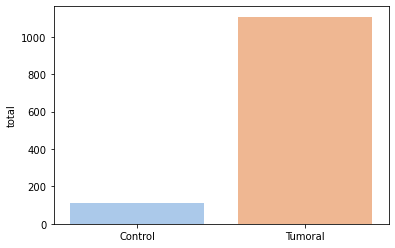

In [73]:
tot_norm = all_normal['sample'].nunique()
tot_tum = all_tumoral['sample'].nunique()

print('Number of normal samples is', tot_norm, 
      'that is the {0:.0f}%'.format(100*tot_norm/all_samples.shape[0],'of the samples'))
print('Number of tumoral samples is', tot_tum, 
      'that is the {0:.0f}%'.format(100*tot_tum/all_samples.shape[0], 'of the samples'))

normal_vs_tum = pd.DataFrame({'Control':[tot_norm], 'Tumoral':[tot_tum]}, index = ['total']).T
_ = sns.barplot(x = ['Control', 'Tumoral'], y = "total", data = normal_vs_tum, palette="pastel")

# 3. Preprocessing
Data preprocessing is the phase of preparing the raw data to make it suitable for a machine learning model. 
In general, in this step we check that:

- each observation is represented by a single row 
- each column should be a feature
- the dataset will be partitioned into at least two sets: the model shall be trained on a significant portion of our dataset (so-called “train set”) and tested on a smaller set (“test set”).
- categorical data is encoded, which means converting labels into integers, because machine learning expects numbers not strings.

Our matrix is composed of: 1221 rows [samples (113 normal + 1108 tumoral)] × 60484 columns genes

So, since the matrix is quite large we have to perform a kind of feature selection to faster and make more accurate our classification. 
We start removing all genes (columns) with a fpkm=0 in all samples obtaining a matrix of 1221 rows × 58274 columns.

In [6]:
matrix=all_samples.iloc[:,:-1]
matrix=matrix.loc[:,(matrix!=0).any(axis=0)]
matrix

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
sample,,,,,,,,,,,,,,,,,,,,,
norm_0,17.383716,7.613039,20.921766,3.277933,0.724987,1.665395,4.546932,14.745758,8.509043,9.399467,...,0.203187,0.044792,0.0,0.000000,0.000000,0.000000,0.884410,0.113089,0.070909,0.0
norm_1,23.881664,1.902087,33.964024,5.563749,1.394149,2.440051,10.064257,12.852097,5.983627,16.166428,...,0.086852,0.000000,0.0,0.000000,0.000000,0.580344,1.070820,0.000000,0.000000,0.0
norm_10,13.670401,29.376414,22.255562,2.818505,0.812117,4.184719,43.764853,24.058912,10.638887,8.019287,...,0.151087,0.008229,0.0,0.000000,0.000000,0.000000,0.255048,0.000000,0.021711,0.0
norm_100,10.712531,10.914004,20.645938,2.140947,0.655884,28.514562,15.466667,27.660185,5.549326,5.291877,...,0.038452,0.020344,0.0,0.000000,0.026308,0.000000,0.840744,0.192614,0.080515,0.0
norm_101,22.204029,10.930857,27.359057,5.101026,1.355944,3.652690,11.595306,16.900551,7.375122,13.889465,...,0.071801,0.006331,0.0,0.180122,0.000000,0.274157,0.988461,0.119889,0.116934,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tum_995,27.103551,0.016726,42.121612,1.832914,8.226989,3.829194,2.177083,35.567062,4.149192,25.214887,...,0.159274,0.000000,0.0,0.000000,0.000000,0.000000,0.236214,0.043293,0.000000,0.0
tum_996,11.793734,0.387014,22.894333,8.296850,2.137033,1.781077,4.433447,13.286886,2.301227,17.304238,...,0.195333,0.000000,0.0,0.000000,0.019092,0.000000,0.881296,0.000000,0.233718,0.0
tum_997,13.182012,0.009637,63.140944,6.248495,3.666258,3.702412,9.164405,28.275274,6.563246,22.452595,...,0.110976,0.007904,0.0,0.000000,0.000000,0.000000,0.471810,0.000000,0.208539,0.0


Despite the removing of all zero, we have with 58274 genes which are still too many. 
So, we will use a t-test, comparing the tumoral group and the normal one.
So, we re-devided our total matrix in the two ones according to the sample and then perform the test.

In [17]:
norm_matrix=matrix.reset_index()
norm_matrix=norm_matrix[norm_matrix['sample'].str.contains(r'norm')].set_index('sample')
norm_matrix

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
sample,,,,,,,,,,,,,,,,,,,,,
norm_0,17.383716,7.613039,20.921766,3.277933,0.724987,1.665395,4.546932,14.745758,8.509043,9.399467,...,0.203187,0.044792,0.0,0.000000,0.000000,0.000000,0.884410,0.113089,0.070909,0.0
norm_1,23.881664,1.902087,33.964024,5.563749,1.394149,2.440051,10.064257,12.852097,5.983627,16.166428,...,0.086852,0.000000,0.0,0.000000,0.000000,0.580344,1.070820,0.000000,0.000000,0.0
norm_10,13.670401,29.376414,22.255562,2.818505,0.812117,4.184719,43.764853,24.058912,10.638887,8.019287,...,0.151087,0.008229,0.0,0.000000,0.000000,0.000000,0.255048,0.000000,0.021711,0.0
norm_100,10.712531,10.914004,20.645938,2.140947,0.655884,28.514562,15.466667,27.660185,5.549326,5.291877,...,0.038452,0.020344,0.0,0.000000,0.026308,0.000000,0.840744,0.192614,0.080515,0.0
norm_101,22.204029,10.930857,27.359057,5.101026,1.355944,3.652690,11.595306,16.900551,7.375122,13.889465,...,0.071801,0.006331,0.0,0.180122,0.000000,0.274157,0.988461,0.119889,0.116934,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
norm_95,14.515773,1.995315,22.688382,4.850862,1.376816,3.388092,13.219148,15.763142,6.611683,17.922908,...,0.137634,0.000000,0.0,0.000000,0.000000,0.193615,1.170294,0.000000,0.141568,0.0
norm_96,26.554725,4.129601,36.501880,2.977751,1.306926,2.177645,9.596998,15.106151,7.541114,8.390678,...,0.032089,0.059421,0.0,0.000000,0.000000,0.000000,1.052419,0.000000,0.111985,0.0
norm_97,23.137497,11.878367,25.514665,3.941593,0.905322,3.282290,10.604422,21.505928,9.155656,10.538901,...,0.131734,0.007623,0.0,0.000000,0.039431,0.110030,0.673824,0.048116,0.100565,0.0


In [18]:
tum_matrix=matrix.reset_index()
tum_matrix=tum_matrix[tum_matrix['sample'].str.contains(r'tum')].set_index('sample')
tum_matrix

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
sample,,,,,,,,,,,,,,,,,,,,,
tum_0,15.752438,0.070065,30.681041,4.558432,2.579139,0.885994,9.453277,24.492556,10.038721,17.848583,...,0.084232,0.000000,0.0,0.0,0.000000,0.0,0.461772,0.155449,0.021660,0.0
tum_1,3.293008,0.000000,58.790723,10.826620,4.237957,0.723620,10.267555,14.035519,7.514246,20.990645,...,0.232806,0.000000,0.0,0.0,0.000000,0.0,0.101887,0.000000,0.133815,0.0
tum_10,4.522393,0.100966,53.623923,3.357538,1.698108,5.615034,6.293319,17.062576,2.026418,9.334165,...,0.029813,0.000000,0.0,0.0,0.000000,0.0,0.808023,0.348457,0.072829,0.0
tum_100,7.761083,0.314845,32.574839,14.440874,2.053589,1.490846,4.080421,10.068724,2.710947,10.467292,...,0.151576,0.000000,0.0,0.0,0.000000,0.0,1.211508,0.000000,0.029623,0.0
tum_1000,11.178320,0.205434,30.964924,5.764519,4.916191,1.171779,3.899895,32.283325,5.675879,17.150652,...,0.468949,0.000000,0.0,0.0,0.033521,0.0,0.587701,0.040904,0.068393,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tum_995,27.103551,0.016726,42.121612,1.832914,8.226989,3.829194,2.177083,35.567062,4.149192,25.214887,...,0.159274,0.000000,0.0,0.0,0.000000,0.0,0.236214,0.043293,0.000000,0.0
tum_996,11.793734,0.387014,22.894333,8.296850,2.137033,1.781077,4.433447,13.286886,2.301227,17.304238,...,0.195333,0.000000,0.0,0.0,0.019092,0.0,0.881296,0.000000,0.233718,0.0
tum_997,13.182012,0.009637,63.140944,6.248495,3.666258,3.702412,9.164405,28.275274,6.563246,22.452595,...,0.110976,0.007904,0.0,0.0,0.000000,0.0,0.471810,0.000000,0.208539,0.0


We store the results (statistic and pvalue for each gene) in a dataframe and then append these results to the matrix with all samples.

In [19]:
stat2, p2 = ttest_ind(tum_matrix, norm_matrix, axis=0)
stats2=pd.DataFrame({'statistic': stat2, 'pvalue': p2}, index=matrix.columns)
stats2

,statistic,pvalue
ENSG00000000003.13,-7.110941,1.958990e-12
ENSG00000000005.5,-12.268193,1.043656e-32
ENSG00000000419.11,5.657900,1.908210e-08
ENSG00000000457.12,5.159291,2.891213e-07
ENSG00000000460.15,9.563707,6.037836e-21
...,...,...
ENSG00000281910.1,0.290339,7.716066e-01
ENSG00000281912.1,1.000526,3.172545e-01
ENSG00000281918.1,-0.131784,8.951771e-01
ENSG00000281920.1,2.068073,3.884368e-02


In [20]:
matrix=matrix.append(stats2.T)
matrix

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
norm_0,1.738372e+01,7.613039e+00,2.092177e+01,3.277933e+00,7.249870e-01,1.665395,4.546932e+00,14.745758,8.509043,9.399467,...,0.203187,0.044792,0.000000,0.000000,0.000000,0.000000,0.884410,0.113089,0.070909,0.000000
norm_1,2.388166e+01,1.902087e+00,3.396402e+01,5.563749e+00,1.394149e+00,2.440051,1.006426e+01,12.852097,5.983627,16.166428,...,0.086852,0.000000,0.000000,0.000000,0.000000,0.580344,1.070820,0.000000,0.000000,0.000000
norm_10,1.367040e+01,2.937641e+01,2.225556e+01,2.818505e+00,8.121174e-01,4.184719,4.376485e+01,24.058912,10.638887,8.019287,...,0.151087,0.008229,0.000000,0.000000,0.000000,0.000000,0.255048,0.000000,0.021711,0.000000
norm_100,1.071253e+01,1.091400e+01,2.064594e+01,2.140947e+00,6.558844e-01,28.514562,1.546667e+01,27.660185,5.549326,5.291877,...,0.038452,0.020344,0.000000,0.000000,0.026308,0.000000,0.840744,0.192614,0.080515,0.000000
norm_101,2.220403e+01,1.093086e+01,2.735906e+01,5.101026e+00,1.355944e+00,3.652690,1.159531e+01,16.900551,7.375122,13.889465,...,0.071801,0.006331,0.000000,0.180122,0.000000,0.274157,0.988461,0.119889,0.116934,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tum_997,1.318201e+01,9.636828e-03,6.314094e+01,6.248495e+00,3.666258e+00,3.702412,9.164405e+00,28.275274,6.563246,22.452595,...,0.110976,0.007904,0.000000,0.000000,0.000000,0.000000,0.471810,0.000000,0.208539,0.000000
tum_998,1.455308e+01,1.028416e-02,2.116672e+01,7.101228e+00,2.977410e+00,1.158167,1.492107e+00,12.822729,10.408357,13.577067,...,0.086545,0.000000,0.000000,0.000000,0.021815,0.000000,1.403999,0.106479,0.422840,0.000000
tum_999,7.599640e+00,7.349349e-01,2.709104e+01,5.312787e+00,1.709141e+00,9.444899,7.704059e+00,19.528096,9.134510,13.128935,...,0.056836,0.009568,0.000000,0.000000,0.000000,0.000000,0.669989,0.060391,0.201953,0.000000
statistic,-7.110941e+00,-1.226819e+01,5.657900e+00,5.159291e+00,9.563707e+00,-3.457542,-1.659108e+01,4.464594,-4.337375,4.468016,...,0.986513,-2.972912,-0.252886,0.914475,0.836869,0.290339,1.000526,-0.131784,2.068073,0.722150


It is always good practice perform a multiple testing correction of the pvalue, and in this case we use the Bonferroni method (since we want to be more stringent as possible in order to reduce the number of genes).

In [21]:
pv_adj=smt.multipletests(matrix.T.pvalue, alpha=0.001, method='bonferroni')
pvadj=pd.DataFrame({'pvalue_adj': pv_adj[1]}, index=matrix.columns)
matrix=matrix.append(pvadj.T)
matrix

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
norm_0,1.738372e+01,7.613039e+00,2.092177e+01,3.277933e+00,7.249870e-01,1.665395,4.546932e+00,14.745758,8.509043,9.399467,...,0.203187,0.044792,0.000000,0.000000,0.000000,0.000000,0.884410,0.113089,0.070909,0.000000
norm_1,2.388166e+01,1.902087e+00,3.396402e+01,5.563749e+00,1.394149e+00,2.440051,1.006426e+01,12.852097,5.983627,16.166428,...,0.086852,0.000000,0.000000,0.000000,0.000000,0.580344,1.070820,0.000000,0.000000,0.000000
norm_10,1.367040e+01,2.937641e+01,2.225556e+01,2.818505e+00,8.121174e-01,4.184719,4.376485e+01,24.058912,10.638887,8.019287,...,0.151087,0.008229,0.000000,0.000000,0.000000,0.000000,0.255048,0.000000,0.021711,0.000000
norm_100,1.071253e+01,1.091400e+01,2.064594e+01,2.140947e+00,6.558844e-01,28.514562,1.546667e+01,27.660185,5.549326,5.291877,...,0.038452,0.020344,0.000000,0.000000,0.026308,0.000000,0.840744,0.192614,0.080515,0.000000
norm_101,2.220403e+01,1.093086e+01,2.735906e+01,5.101026e+00,1.355944e+00,3.652690,1.159531e+01,16.900551,7.375122,13.889465,...,0.071801,0.006331,0.000000,0.180122,0.000000,0.274157,0.988461,0.119889,0.116934,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tum_998,1.455308e+01,1.028416e-02,2.116672e+01,7.101228e+00,2.977410e+00,1.158167,1.492107e+00,12.822729,10.408357,13.577067,...,0.086545,0.000000,0.000000,0.000000,0.021815,0.000000,1.403999,0.106479,0.422840,0.000000
tum_999,7.599640e+00,7.349349e-01,2.709104e+01,5.312787e+00,1.709141e+00,9.444899,7.704059e+00,19.528096,9.134510,13.128935,...,0.056836,0.009568,0.000000,0.000000,0.000000,0.000000,0.669989,0.060391,0.201953,0.000000
statistic,-7.110941e+00,-1.226819e+01,5.657900e+00,5.159291e+00,9.563707e+00,-3.457542,-1.659108e+01,4.464594,-4.337375,4.468016,...,0.986513,-2.972912,-0.252886,0.914475,0.836869,0.290339,1.000526,-0.131784,2.068073,0.722150
pvalue,1.958990e-12,1.043656e-32,1.908210e-08,2.891213e-07,6.037836e-21,0.000564,6.767450e-56,0.000009,0.000016,0.000009,...,0.324077,0.003008,0.800399,0.360648,0.402830,0.771607,0.317254,0.895177,0.038844,0.470341


Moreover, we compute the log2fold-change that will use together with the pvalue to select the most relevant genes only.
Essentialy, the fold-change is defined as the ratio between the two quantities, in particular it is often used in analysis of gene expression data for measuring change in the expression level of a gene.

In [22]:
# fold change
mean_gene_tum=np.mean(tum_matrix,axis=0)
mean_gene_norm=np.mean(norm_matrix,axis=0)
log2_fold_change=abs((np.log2(mean_gene_tum))-(np.log2(mean_gene_norm)))
fc=pd.DataFrame({'log2FC': log2_fold_change}, index=matrix.columns)
matrix=matrix.append(fc.T)
matrix

/home/mariachiara/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
norm_0,1.738372e+01,7.613039e+00,2.092177e+01,3.277933e+00,7.249870e-01,1.665395,4.546932e+00,14.745758,8.509043,9.399467,...,0.203187,0.044792,0.000000,0.000000,0.000000,0.000000,0.884410,0.113089,0.070909,0.000000
norm_1,2.388166e+01,1.902087e+00,3.396402e+01,5.563749e+00,1.394149e+00,2.440051,1.006426e+01,12.852097,5.983627,16.166428,...,0.086852,0.000000,0.000000,0.000000,0.000000,0.580344,1.070820,0.000000,0.000000,0.000000
norm_10,1.367040e+01,2.937641e+01,2.225556e+01,2.818505e+00,8.121174e-01,4.184719,4.376485e+01,24.058912,10.638887,8.019287,...,0.151087,0.008229,0.000000,0.000000,0.000000,0.000000,0.255048,0.000000,0.021711,0.000000
norm_100,1.071253e+01,1.091400e+01,2.064594e+01,2.140947e+00,6.558844e-01,28.514562,1.546667e+01,27.660185,5.549326,5.291877,...,0.038452,0.020344,0.000000,0.000000,0.026308,0.000000,0.840744,0.192614,0.080515,0.000000
norm_101,2.220403e+01,1.093086e+01,2.735906e+01,5.101026e+00,1.355944e+00,3.652690,1.159531e+01,16.900551,7.375122,13.889465,...,0.071801,0.006331,0.000000,0.180122,0.000000,0.274157,0.988461,0.119889,0.116934,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tum_999,7.599640e+00,7.349349e-01,2.709104e+01,5.312787e+00,1.709141e+00,9.444899,7.704059e+00,19.528096,9.134510,13.128935,...,0.056836,0.009568,0.000000,0.000000,0.000000,0.000000,0.669989,0.060391,0.201953,0.000000
statistic,-7.110941e+00,-1.226819e+01,5.657900e+00,5.159291e+00,9.563707e+00,-3.457542,-1.659108e+01,4.464594,-4.337375,4.468016,...,0.986513,-2.972912,-0.252886,0.914475,0.836869,0.290339,1.000526,-0.131784,2.068073,0.722150
pvalue,1.958990e-12,1.043656e-32,1.908210e-08,2.891213e-07,6.037836e-21,0.000564,6.767450e-56,0.000009,0.000016,0.000009,...,0.324077,0.003008,0.800399,0.360648,0.402830,0.771607,0.317254,0.895177,0.038844,0.470341
pvalue_adj,1.141582e-07,6.081801e-28,1.111991e-03,1.684825e-02,3.518489e-16,1.000000,3.943664e-51,0.510772,0.909681,0.502799,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


According to the pvalue and log2FC we see how many genes are kept setting different thresholds.
Setting pvalue_adjusted < 0.0001 and log2FC>3: we retain just 477, that allows us to reduce the overall higher number of genes.

In [34]:
print('pvalue_adjusted < 0.001 fc>1: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.001) & (matrix.T.log2FC >1)][['pvalue','log2FC']].shape[0])
print('pvalue_adjusted < 0.001 fc>2: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.001) & (matrix.T.log2FC >2)][['pvalue','log2FC']].shape[0])
print('pvalue_adjusted < 0.001 fc>3: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.001) & (matrix.T.log2FC >3)][['pvalue','log2FC']].shape[0])
print('')
print('pvalue_adjusted < 0.0001 fc>3: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.0001) & (matrix.T.log2FC >3)][['pvalue','log2FC']].shape[0],
     '*** used in the downstream analysis***')
print('')
print('pvalue_adjusted < 0.01 fc>1: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.01) & (matrix.T.log2FC >1)][['pvalue','log2FC']].shape[0])
print('pvalue_adjusted < 0.01 fc>2: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.01) & (matrix.T.log2FC >2)][['pvalue','log2FC']].shape[0])
print('pvalue_adjusted < 0.01 fc>3: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.01) & (matrix.T.log2FC >3)][['pvalue','log2FC']].shape[0])
print('')

print('pvalue_adjusted < 0.05 fc>1: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.05) & (matrix.T.log2FC >1)][['pvalue','log2FC']].shape[0])
print('pvalue_adjusted < 0.05 fc>2: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.05) & (matrix.T.log2FC >2)][['pvalue','log2FC']].shape[0])
print('pvalue_adjusted < 0.05 fc>3: samples=',
      matrix.T[(matrix.T.pvalue_adj < 0.05) & (matrix.T.log2FC >3)][['pvalue','log2FC']].shape[0])

Using the NOT normalized matrix
pvalue_adjusted < 0.001 fc>1: samples= 4278
pvalue_adjusted < 0.001 fc>2: samples= 1503
pvalue_adjusted < 0.001 fc>3: samples= 488

pvalue_adjusted < 0.0001 fc>3: samples= 477 *** used in the downstream analysis***

pvalue_adjusted < 0.01 fc>1: samples= 4582
pvalue_adjusted < 0.01 fc>2: samples= 1580
pvalue_adjusted < 0.01 fc>3: samples= 511

pvalue_adjusted < 0.05 fc>1: samples= 4823
pvalue_adjusted < 0.05 fc>2: samples= 1644
pvalue_adjusted < 0.05 fc>3: samples= 530


In [28]:
de=matrix.T[(matrix.T.pvalue_adj < 0.0001) & (matrix.T.log2FC >3)]
de

,norm_0,norm_1,norm_10,norm_100,norm_101,norm_102,norm_103,norm_104,norm_105,norm_106,...,tum_994,tum_995,tum_996,tum_997,tum_998,tum_999,statistic,pvalue,pvalue_adj,log2FC
ENSG00000000005.5,7.613039,1.902087,29.376414,10.914004,10.930857,2.009871,10.083261,0.589315,5.143760,9.413264,...,0.078064,0.016726,0.387014,0.009637,0.010284,0.734935,-12.268193,1.043656e-32,6.081801e-28,3.765643
ENSG00000004776.10,218.295335,14.722002,252.050817,180.833766,60.244043,12.419854,82.625543,18.637677,99.786011,71.719844,...,3.568236,0.359671,7.144291,1.802008,1.144218,6.631391,-30.515843,2.048542e-152,1.193767e-147,4.275305
ENSG00000004799.7,109.333516,245.174326,181.790225,96.860190,131.259135,59.360018,244.719629,2.957658,76.217157,107.798773,...,2.376392,0.718050,7.416822,4.291683,13.772884,37.717119,-26.292837,4.623217e-121,2.694134e-116,3.377168
ENSG00000004846.15,0.581303,0.226796,0.525230,0.349440,1.917233,1.386865,0.590328,0.049019,0.391160,1.772560,...,0.031680,0.001454,0.062614,0.000000,0.055448,0.215065,-29.319455,1.923466e-143,1.120880e-138,3.547686
ENSG00000007314.10,5.175174,0.838364,3.627426,3.505903,4.145829,0.854093,2.031510,0.462691,2.422211,1.452475,...,0.138852,0.029387,0.260046,0.030101,0.108416,0.432705,-15.912059,6.081908e-52,3.544171e-47,3.213484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280362.1,0.401289,0.896532,0.004096,0.187323,0.201679,0.744138,0.348081,0.277175,0.434888,0.491414,...,0.000000,0.013655,0.044089,0.003934,0.083963,0.047621,-27.992560,1.451549e-133,8.458759e-129,3.389420
ENSG00000280429.1,0.232050,0.190185,0.064872,0.309310,0.228176,0.379936,0.030587,0.295841,0.228617,0.100327,...,0.000000,0.007725,0.049881,0.008901,0.000000,0.000000,-18.934439,2.717253e-70,1.583452e-65,3.441716
ENSG00000280436.1,0.000000,0.123807,0.000000,0.000000,0.048739,0.059022,0.026134,0.000000,0.033971,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.395168,2.840980e-38,1.655553e-33,3.320144
ENSG00000281769.1,1.480504,0.036625,0.610356,0.648602,0.181257,0.009977,0.932152,0.020510,0.321582,0.666556,...,0.032401,0.017851,0.192119,0.005143,0.000000,0.087154,-16.283525,4.307192e-54,2.509973e-49,4.469324


In [ ]:
### this is our X (feature matrix) for the classification task
X=de.iloc[:,:-4]

In [37]:
# this is our Y for the classification task
Y= all_samples.iloc[:,-1:]   
Y=Y.reset_index().iloc[:,1]
y=Y.to_numpy().astype(np.int64)

In [39]:
y,Y

(array([1, 1, 1, ..., 0, 0, 0]),
 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 1216    0
 1217    0
 1218    0
 1219    0
 1220    0
 Name: is_healthy, Length: 1221, dtype: int64)

# 4. Classification task

## Feature selection

Until now we have done feature selection, altough is not the most efficient way to do feature selection, on the contrary many other apporaches can be used. One of them is forward feature selection  or backward feature selection. Since we have a very high number of genes they would have been computationally expensive. 
To obtain a perfect solution the correct approach should be Best feature selection but, with this amount of data, is not possible. 
Another approach could has been Principal component analysis (PCA) which is a widely used method for dimensionality reduction, but here the big drawback is the loss of interpretability in the model. In fact, doing PCA, we would end up having some relevant features which are a linear combination of all the features in the data set. What we want to do is try to understand which genes may be relevant so having a linear combination of all of them as a variable would be completely useless.

Focusing on the dataset, we have a total of 1221 samples to be used in order to find a good classification algorithm. However a big problem related to this dataset is that it is highly unbalanced. As we can see from the barplot, among 1221 samples only 113 are control samples, meaning that using the simplest classification method existent, which is predict all the samples 0 (tumoral), we will get anyway an accuracy of 90,7%.
For this reason we should be careful when we read our results in terms of accuracy. To overcome this problem a potential solution is use as metric not only the accuracy also precision and recall for each of the two classes. In this light, an index that summarizes precision and recall is the F1 score. 

Another highlitable aspect is that the two classes seems to be almost completely separable. We can see this by considering only the 2 more differentially expressed, the plot clearly shows how the two classes are differentiated. As a consequence of this, which is obtained considering only 2 features, we expect to have good results and that only few features are needed.

In [40]:
###subset X
subx=pd.concat((X.iloc[0:4,0:4],X.iloc[0:4,-4:]),axis = 1).T
sampletype=[1,1,1,1,0,0,0,0]
subx.insert(4, 'sample_type',sampletype)
subx

,ENSG00000000005.5,ENSG00000004776.10,ENSG00000004799.7,ENSG00000004846.15,sample_type
norm_0,7.613039,218.295335,109.333516,0.581303,1
norm_1,1.902087,14.722002,245.174326,0.226796,1
norm_10,29.376414,252.050817,181.790225,0.525230,1
norm_100,10.914004,180.833766,96.860190,0.349440,1
tum_996,0.387014,7.144291,7.416822,0.062614,0
tum_997,0.009637,1.802008,4.291683,0.000000,0
tum_998,0.010284,1.144218,13.772884,0.055448,0
tum_999,0.734935,6.631391,37.717119,0.215065,0


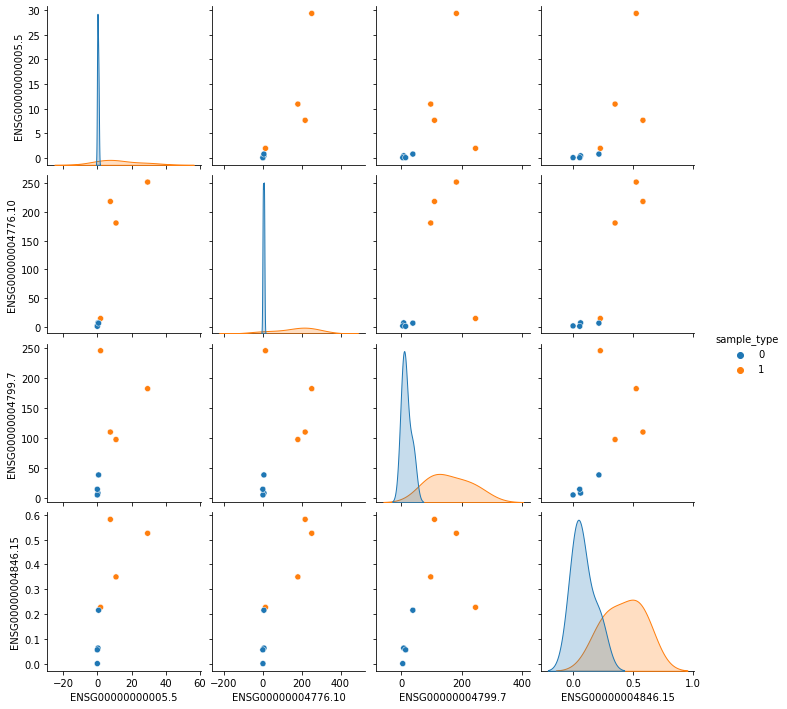

In [41]:
_=sns.pairplot(subx, hue='sample_type') ## to do with few genes

In [42]:
de.sort_values(by=['log2FC','pvalue_adj'], ascending=False)

,norm_0,norm_1,norm_10,norm_100,norm_101,norm_102,norm_103,norm_104,norm_105,norm_106,...,tum_994,tum_995,tum_996,tum_997,tum_998,tum_999,statistic,pvalue,pvalue_adj,log2FC
ENSG00000123500.8,0.170508,0.173738,0.093125,0.162211,0.140048,2.370400,0.122247,0.081077,0.054482,0.156570,...,337.226018,2.625094,47.436014,24.553683,10.764982,6.846254,9.484198,1.231027e-20,7.173688e-16,7.037599
ENSG00000099953.8,0.397505,0.213481,0.312075,0.995297,0.326559,2.044168,0.432608,0.777062,0.261083,0.900925,...,289.885200,1.118548,67.819424,23.584684,24.772279,11.916346,10.121719,3.539818e-23,2.062794e-18,6.189155
ENSG00000060718.17,0.227663,0.387711,0.512050,0.149788,0.269170,0.850412,0.269310,0.371842,0.243161,0.144579,...,283.923495,147.078166,22.388893,0.803454,3.119182,0.595378,7.839426,9.813686e-15,5.718828e-10,6.059072
ENSG00000174697.4,86.091115,5.021775,444.278753,152.507425,66.692061,0.145226,55.422182,1.459502,90.876340,66.121457,...,0.065332,0.051180,0.889770,0.013610,0.000000,1.411371,-26.313492,3.267474e-121,1.904088e-116,5.930684
ENSG00000232679.1,0.000000,0.000000,0.000000,0.106589,0.022115,0.107122,0.000000,0.000000,0.000000,0.000000,...,6.435726,0.191661,2.423685,0.055215,1.178470,0.033419,7.539134,9.201859e-14,5.362291e-09,5.736516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000137727.11,5.888935,2.762715,3.185261,1.308758,3.073533,3.050267,2.585251,1.152162,3.083281,3.775545,...,0.811427,0.462979,0.538946,0.383255,0.132460,0.445488,-45.803006,3.088627e-267,1.799867e-262,3.005420
ENSG00000148773.11,0.194981,0.390721,0.292613,1.914601,0.222231,0.431295,0.686872,1.726485,2.322745,1.544064,...,2.849221,40.998131,5.148119,9.467636,12.333770,4.921628,10.504062,9.108979e-25,5.308166e-20,3.003758
ENSG00000255471.1,15.130914,2.164331,18.566684,4.901750,6.704014,2.248949,4.727331,0.677373,6.415167,4.761772,...,1.100672,0.033163,1.201597,0.484057,0.394226,0.570543,-28.245707,1.924559e-135,1.121517e-130,3.001865
ENSG00000224318.4,0.398309,0.786586,0.384160,0.316588,0.380032,0.238629,1.207560,0.210231,0.294313,0.412584,...,0.000000,0.000000,0.213338,0.017571,0.000000,0.212703,-27.223306,6.982517e-128,4.068992e-123,3.001475


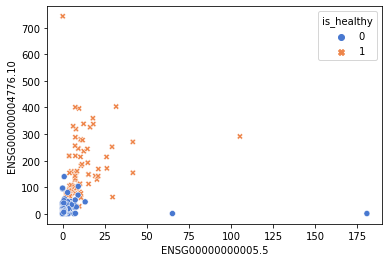

In [43]:
sub_two_genes=de.iloc[:,:-4].T.iloc[:,[0,1]]
sub_two_genes.insert(2,"is_healthy",Y.reset_index()[["is_healthy"]])
_=sns.scatterplot(data=sub_two_genes,
#                   x=pd.concat((sub_two_genes.iloc[0:101,0],sub_two_genes.iloc[115:216,0]),axis = 0), 
#                   y=pd.concat((sub_two_genes.iloc[0:101,1],sub_two_genes.iloc[115:216,1]),axis = 0), 
                  x=sub_two_genes.iloc[:,0],
                  y=sub_two_genes.iloc[:,1],
                  hue='is_healthy', hue_order=[0,1], 
                  palette= 'muted', style='is_healthy')


In [57]:
X
#our feature matrix

,norm_0,norm_1,norm_10,norm_100,norm_101,norm_102,norm_103,norm_104,norm_105,norm_106,...,tum_990,tum_991,tum_992,tum_993,tum_994,tum_995,tum_996,tum_997,tum_998,tum_999
ENSG00000000005.5,7.613039,1.902087,29.376414,10.914004,10.930857,2.009871,10.083261,0.589315,5.143760,9.413264,...,0.056994,0.161233,0.044047,0.108222,0.078064,0.016726,0.387014,0.009637,0.010284,0.734935
ENSG00000004776.10,218.295335,14.722002,252.050817,180.833766,60.244043,12.419854,82.625543,18.637677,99.786011,71.719844,...,2.291355,7.548913,0.609498,4.211737,3.568236,0.359671,7.144291,1.802008,1.144218,6.631391
ENSG00000004799.7,109.333516,245.174326,181.790225,96.860190,131.259135,59.360018,244.719629,2.957658,76.217157,107.798773,...,4.487527,33.476049,2.915729,17.786603,2.376392,0.718050,7.416822,4.291683,13.772884,37.717119
ENSG00000004846.15,0.581303,0.226796,0.525230,0.349440,1.917233,1.386865,0.590328,0.049019,0.391160,1.772560,...,0.006608,0.049613,0.004596,0.055290,0.031680,0.001454,0.062614,0.000000,0.055448,0.215065
ENSG00000007314.10,5.175174,0.838364,3.627426,3.505903,4.145829,0.854093,2.031510,0.462691,2.422211,1.452475,...,0.063051,0.213070,0.073951,0.323512,0.138852,0.029387,0.260046,0.030101,0.108416,0.432705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280362.1,0.401289,0.896532,0.004096,0.187323,0.201679,0.744138,0.348081,0.277175,0.434888,0.491414,...,0.000000,0.536668,0.000000,0.016567,0.000000,0.013655,0.044089,0.003934,0.083963,0.047621
ENSG00000280429.1,0.232050,0.190185,0.064872,0.309310,0.228176,0.379936,0.030587,0.295841,0.228617,0.100327,...,0.070194,0.034368,0.008137,0.006248,0.000000,0.007725,0.049881,0.008901,0.000000,0.000000
ENSG00000280436.1,0.000000,0.123807,0.000000,0.000000,0.048739,0.059022,0.026134,0.000000,0.033971,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000281769.1,1.480504,0.036625,0.610356,0.648602,0.181257,0.009977,0.932152,0.020510,0.321582,0.666556,...,0.000000,0.000000,0.009402,0.018047,0.032401,0.017851,0.192119,0.005143,0.000000,0.087154


In [45]:
newX=X.T.to_numpy() #convert to numpy arrays

In [542]:
Y=Y.reset_index().iloc[:,1]
y=Y.to_numpy().astype(np.int64)

In [46]:
newX
y

array([[7.61303914e+00, 2.18295335e+02, 1.09333516e+02, ...,
        0.00000000e+00, 1.48050394e+00, 0.00000000e+00],
       [1.90208674e+00, 1.47220015e+01, 2.45174326e+02, ...,
        1.23806737e-01, 3.66249629e-02, 0.00000000e+00],
       [2.93764145e+01, 2.52050817e+02, 1.81790225e+02, ...,
        0.00000000e+00, 6.10355879e-01, 9.91851786e-01],
       ...,
       [9.63682799e-03, 1.80200849e+00, 4.29168319e+00, ...,
        0.00000000e+00, 5.14262282e-03, 0.00000000e+00],
       [1.02841646e-02, 1.14421782e+00, 1.37728836e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.34934936e-01, 6.63139124e+00, 3.77171190e+01, ...,
        0.00000000e+00, 8.71539239e-02, 1.64751496e-01]])

array([1, 1, 1, ..., 0, 0, 0])

We can now split data into training and test sets

In [708]:
#Percentage of data used for the test
test_size = 0.3

#Seed used for the division of all data
test_seed = 97

X_train, X_test, y_train, y_test = train_test_split(newX, y,
                                                    test_size=test_size, 
                                                    random_state=test_seed)


We will compare different algorithms, in particular:
- Logistic Regression
- Decision Tree
- KNeighbors
- Linear Discriminant 
- Support vector machine
- Random Forest


In [ ]:
logreg = LogisticRegression(solver="newton-cg", penalty='none')
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()
svm = SVC()
rf = RandomForestClassifier()

In [ ]:
models = OrderedDict([('LogisticRegression', logreg), ('DecisionTree', dt), ('KNN', knn),
                      ('LDA', lda), ('SVM', svm), ('RandomForest', rf)])
# I use OrderedDict insteaf of simple dict because OrderedDict preserves the order in which the keys are inserted. 
#A regular dict doesn’t track the insertion order, and iterating it gives the values in an arbitrary order. 
#By contrast, the order the items are inserted is remembered by OrderedDict.

As we can see form also the barplot, all the algorithms performs well.
We have to remember that we are using a very unbalanced dataset.

LogisticRegression(penalty='none', solver='newton-cg')

LogisticRegression CV score: 0.9824,  test score 0.9891


DecisionTreeClassifier()

DecisionTree CV score: 0.9813,  test score 0.9700


KNeighborsClassifier()

KNN CV score: 0.9801,  test score 0.9809


LinearDiscriminantAnalysis()

LDA CV score: 0.9695,  test score 0.9646


SVC()

SVM CV score: 0.9848,  test score 0.9837


RandomForestClassifier()

RandomForest CV score: 0.9930,  test score 0.9891


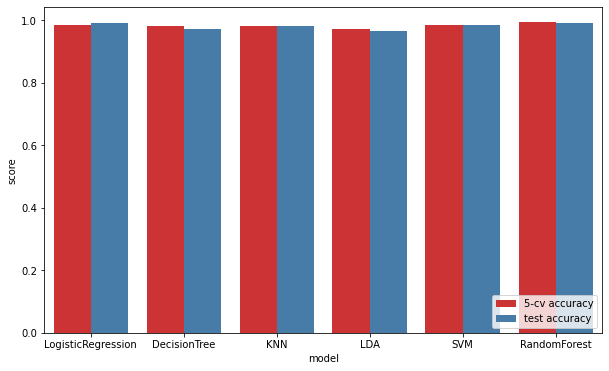

In [541]:
cv_scores, test_scores = [], []

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, 
                             scoring=make_scorer(accuracy), cv=5)
    cv_score = np.mean(scores)
    cv_scores.append(cv_score)
    
    model.fit(X_train, y_train)
    test_score = accuracy(y_test, model.predict(X_test))
    test_scores.append(test_score)
    print("{} CV score: {:.4f},  test score {:.4f}".format(name, cv_score, test_score))
    

data = pd.DataFrame()
data['model'] = list(models.keys()) * 2
data['metric'] = ['5-cv accuracy'] * len(cv_scores) + ['test accuracy'] * len(test_scores)
data['score'] = cv_scores + test_scores


_=plt.figure(figsize = (10,6))
_=sns.barplot(x='model', y='score', data=data, hue='metric', palette='Set1')
_=plt.legend(loc='lower right')

We can investigate which is the best number of features for the algorithms using an increasing number of features.
So we divide the whole data set in train set and test set and perform also cross-validation.
From the lineplot we can clearly understand a common trend for all the algorithms, all of them tend to perform better when more than 50 features are used, even if a sort of 'plateau' is then reached.

In [486]:
test_size = 0.3
seed = 97

#Using kfold we will get different train and validation set that can be used to train the models
#In this case we will k = 5
folds = 5
kfold = KFold(n_splits=folds, random_state=seed, shuffle = True)

In [710]:
features=[2,3,5,10,15,20,25,30,35,40,50,60,75,80,90,
          102,103,105,100,115,120,125,130,150,175,190,
          202,203,205,210,215,220,225,230,250,275,290,
          302,303,305,310,315,320,325,330,350,375,390,
          402,403,405,410,415,420,425,430,450,477]

z = pd.DataFrame()
data= pd.DataFrame()

for f in features:
    subX=X.T.iloc[:,:f]
    newX=subX.to_numpy()
    
    #Dividing the dataset in train and test set
    X_train, X_test, y_train, y_test = train_test_split(newX, y,test_size=test_size,random_state=seed)
    cv_scores, test_scores = [], []
    
    for name, model in models.items():
        
        cv_scores, test_scores = [], []
        scores = cross_val_score(model, 
                                X_train, y_train,
                                scoring=make_scorer(accuracy), 
                                cv=5)
        
        cv_score = np.mean(scores)
        cv_scores.append(cv_score)
        
        model.fit(X_train, y_train)
        test_score = accuracy(y_test, model.predict(X_test))
        test_scores.append(test_score)
        
        data_feat=pd.DataFrame()
        data_feat['model'] = [name] *2
        data_feat['features'] = [f] *2
        data_feat['metric'] = ['5-cv accuracy'] * len(cv_scores) + ['test accuracy'] * len(test_scores)
        data_feat['score'] = cv_scores + test_scores
        
        data=pd.concat([data,data_feat],axis=0)
    


array([1, 1, 1, ..., 0, 0, 0])

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

/home/mariachiara/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

/home/mariachiara/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

In [711]:
data

,model,features,metric,score
0,LogisticRegression,2,5-cv accuracy,0.958982
1,LogisticRegression,2,test accuracy,0.945504
0,DecisionTree,2,5-cv accuracy,0.939057
1,DecisionTree,2,test accuracy,0.953678
0,KNN,2,5-cv accuracy,0.956629
...,...,...,...,...
1,LDA,477,test accuracy,0.975477
0,SVM,477,5-cv accuracy,0.984775
1,SVM,477,test accuracy,0.983651
0,RandomForest,477,5-cv accuracy,0.990630


In [712]:
df_5cv=data[data.loc[:,'metric']=='5-cv accuracy']
df_test=data[data.loc[:,'metric']=='test accuracy']
df_5cv=df_5cv.reset_index().iloc[:,1:]
df_test=df_test.reset_index().iloc[:,1:]

df_5cv
df_test

,model,features,metric,score
0,LogisticRegression,2,5-cv accuracy,0.958982
1,DecisionTree,2,5-cv accuracy,0.939057
2,KNN,2,5-cv accuracy,0.956629
3,LDA,2,5-cv accuracy,0.950795
4,SVM,2,5-cv accuracy,0.957819
...,...,...,...,...
343,DecisionTree,477,5-cv accuracy,0.981266
344,KNN,477,5-cv accuracy,0.980089
345,LDA,477,5-cv accuracy,0.968394
346,SVM,477,5-cv accuracy,0.984775


,model,features,metric,score
0,LogisticRegression,2,test accuracy,0.945504
1,DecisionTree,2,test accuracy,0.953678
2,KNN,2,test accuracy,0.950954
3,LDA,2,test accuracy,0.934605
4,SVM,2,test accuracy,0.945504
...,...,...,...,...
343,DecisionTree,477,test accuracy,0.972752
344,KNN,477,test accuracy,0.980926
345,LDA,477,test accuracy,0.975477
346,SVM,477,test accuracy,0.983651


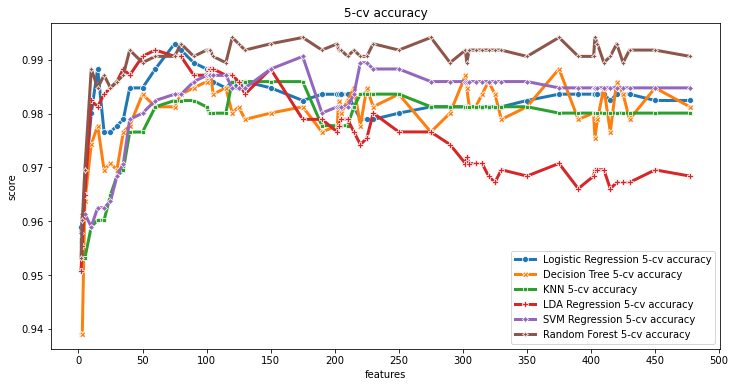

In [715]:
# 5cv all features
_=plt.figure(figsize = (12,6))
_=sns.lineplot(data=df_5cv,
               x='features',
               y='score',
               hue='model',
               style='model',
               markers=True,dashes=False,
               linewidth = 3)
_=_.set_xticks(range(0,501,50))
_=plt.legend(title='', loc='lower right', labels=['Logistic Regression 5-cv accuracy',
                                                                    'Decision Tree 5-cv accuracy',
                                                                    'KNN 5-cv accuracy',
                                                                    'LDA Regression 5-cv accuracy',
                                                                    'SVM Regression 5-cv accuracy',
                                                                    'Random Forest 5-cv accuracy'])
_=plt.title('5-cv accuracy')

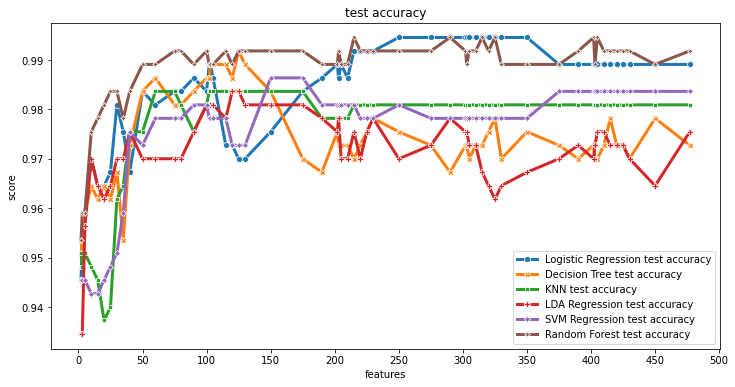

In [717]:
# test score all features
print('')
_=plt.figure(figsize = (12,6))
_=sns.lineplot(data=df_test,
               x='features',
               y='score',
               hue='model',
               style='model',
               markers=True,dashes=False,
               linewidth = 3)
_=_.set_xticks(range(0,501,50))
_=plt.legend(title='', loc='lower right', labels=['Logistic Regression test accuracy',
                                                                    'Decision Tree test accuracy',
                                                                    'KNN test accuracy',
                                                                    'LDA Regression test accuracy',
                                                                    'SVM Regression test accuracy',
                                                                    'Random Forest test accuracy'])
_=plt.title('test accuracy')

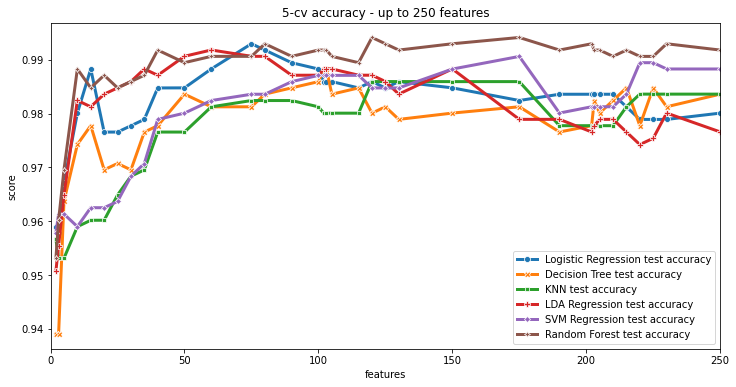

In [719]:
# 5-cv score up to 250 features to better visualize
print('')
_=plt.figure(figsize = (12,6))
_=sns.lineplot(data=df_5cv,
               x='features',
               y='score',
               hue='model',
               style='model',
               markers=True,dashes=False,
               linewidth = 3)
_=_.set_xlim(0,250,25)
_=plt.legend(title='', loc='lower right', labels=['Logistic Regression test accuracy',
                                                                    'Decision Tree test accuracy',
                                                                    'KNN test accuracy',
                                                                    'LDA Regression test accuracy',
                                                                    'SVM Regression test accuracy',
                                                                    'Random Forest test accuracy'])
_=plt.title('5-cv accuracy - up to 250 features')

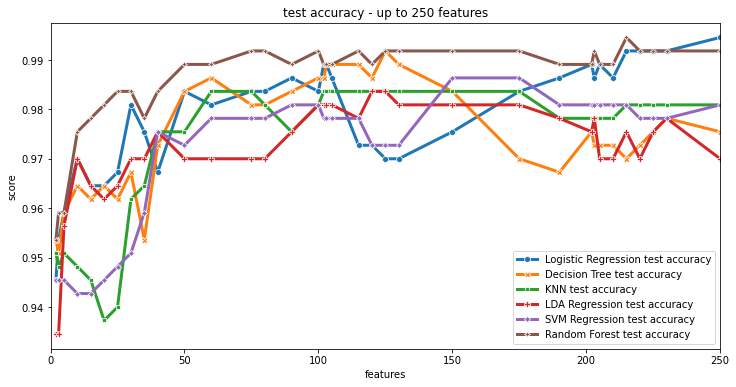

In [720]:
# test score up to 250 features to better visualize
print('')
_=plt.figure(figsize = (12,6))
_=sns.lineplot(data=df_test,
               x='features',
               y='score',
               hue='model',
               style='model',
               markers=True,dashes=False,
               linewidth = 3)
_=_.set_xlim(0,250,25)
_=plt.legend(title='', loc='lower right', labels=['Logistic Regression test accuracy',
                                                                    'Decision Tree test accuracy',
                                                                    'KNN test accuracy',
                                                                    'LDA Regression test accuracy',
                                                                    'SVM Regression test accuracy',
                                                                    'Random Forest test accuracy'])
_=plt.title('test accuracy - up to 250 features')

In the plots above we have compared the differents algorithm in terms of accuracy (on the y axis).
Classification accuracy is the simplest out of all the methods of evaluating the accuracy, and the most commonly used; simply, it the number of correct predictions divided by all predictions or a ratio of correct predictions to total predictions.

While it can give you a quick idea of how your classifier is performing, it is best used when the number of observations/examples in each class is roughly equivalent, in other case it is better use other metrics.

# 5. Evaluation metrics

### Area Under ROC Curve (AUC)


This is a metric used only for binary classification problems. The area under the curve represents the model's ability to properly discriminate between negative and positive examples, between one class or another.

A 1.0, all of the area falling under the curve, represents a perfect classifier. This means that an AUC of 0.5 is basically as good as randomly guessing. The ROC curve is calculated with regards to sensitivity (true positive rate/recall) and specificity (true negative rate)

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC(probability=True)

RandomForestClassifier()

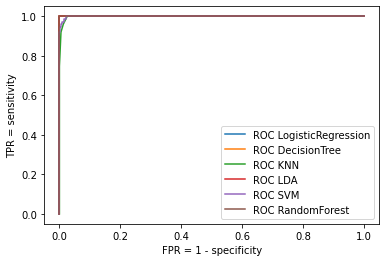

In [421]:
#Area Under ROC Curve (AUC)
logreg = LogisticRegression(solver="newton-cg", penalty='none')
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()
svm = SVC(probability=True)
rf = RandomForestClassifier()

models = OrderedDict([('LogisticRegression', logreg), ('DecisionTree', dt), ('KNN', knn),
                      ('LDA', lda), ('SVM', svm), ('RandomForest', rf)])

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])    
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()
    
for name, model in models.items():
    model.fit(X_train, y_train)
    plot_roc(model.predict_proba, X_train, y_train, name)

### Classification report

The classification report is a Scikit-Learn built in metric created especially for classification problems. Using the classification report we can have an idea of how our model is performing. Recall pits the number of samples our model labeled as Class A (some given class) against the total number of examples of Class A, and this is represented in the report.

The report also returns precision and f1-score:
- precision is the percentage of examples your model labeled as Class A which actually belonged to Class A (true positives against false positives)
- f1-score is an average of precision and recall.

The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label)

In [808]:
models = OrderedDict([('LogisticRegression', logreg), ('DecisionTree', dt), ('KNN', knn),
                      ('LDA', lda), ('SVM', svm), ('RandomForest', rf)])

for name, model in models.items():
    print(name)
    pd.DataFrame(classification_report(y_test,
                                       model.predict(X_test), 
                                       target_names=['tumoral','normal'], 
                                       output_dict=True))
    print('')

LogisticRegression


,tumoral,normal,accuracy,macro avg,weighted avg
precision,0.990937,0.972222,0.989101,0.981579,0.988999
recall,0.996960,0.921053,0.989101,0.959007,0.989101
f1-score,0.993939,0.945946,0.989101,0.969943,0.988970
support,329.000000,38.000000,0.989101,367.000000,367.000000



DecisionTree


,tumoral,normal,accuracy,macro avg,weighted avg
precision,0.981873,0.888889,0.972752,0.935381,0.972245
recall,0.987842,0.842105,0.972752,0.914974,0.972752
f1-score,0.984848,0.864865,0.972752,0.924857,0.972425
support,329.000000,38.000000,0.972752,367.000000,367.000000



KNN


,tumoral,normal,accuracy,macro avg,weighted avg
precision,0.984940,0.942857,0.980926,0.963898,0.980582
recall,0.993921,0.868421,0.980926,0.931171,0.980926
f1-score,0.989410,0.904110,0.980926,0.946760,0.980578
support,329.000000,38.000000,0.980926,367.000000,367.000000



LDA


,tumoral,normal,accuracy,macro avg,weighted avg
precision,0.981928,0.914286,0.975477,0.948107,0.974924
recall,0.990881,0.842105,0.975477,0.916493,0.975477
f1-score,0.986384,0.876712,0.975477,0.931548,0.975029
support,329.000000,38.000000,0.975477,367.000000,367.000000



SVM


,tumoral,normal,accuracy,macro avg,weighted avg
precision,0.987915,0.944444,0.983651,0.966180,0.983414
recall,0.993921,0.894737,0.983651,0.944329,0.983651
f1-score,0.990909,0.918919,0.983651,0.954914,0.983455
support,329.000000,38.000000,0.983651,367.000000,367.000000



RandomForest


,tumoral,normal,accuracy,macro avg,weighted avg
precision,0.993958,1.000000,0.99455,0.996979,0.994583
recall,1.000000,0.947368,0.99455,0.973684,0.994550
f1-score,0.996970,0.972973,0.99455,0.984971,0.994485
support,329.000000,38.000000,0.99455,367.000000,367.000000


### Classification matrix

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

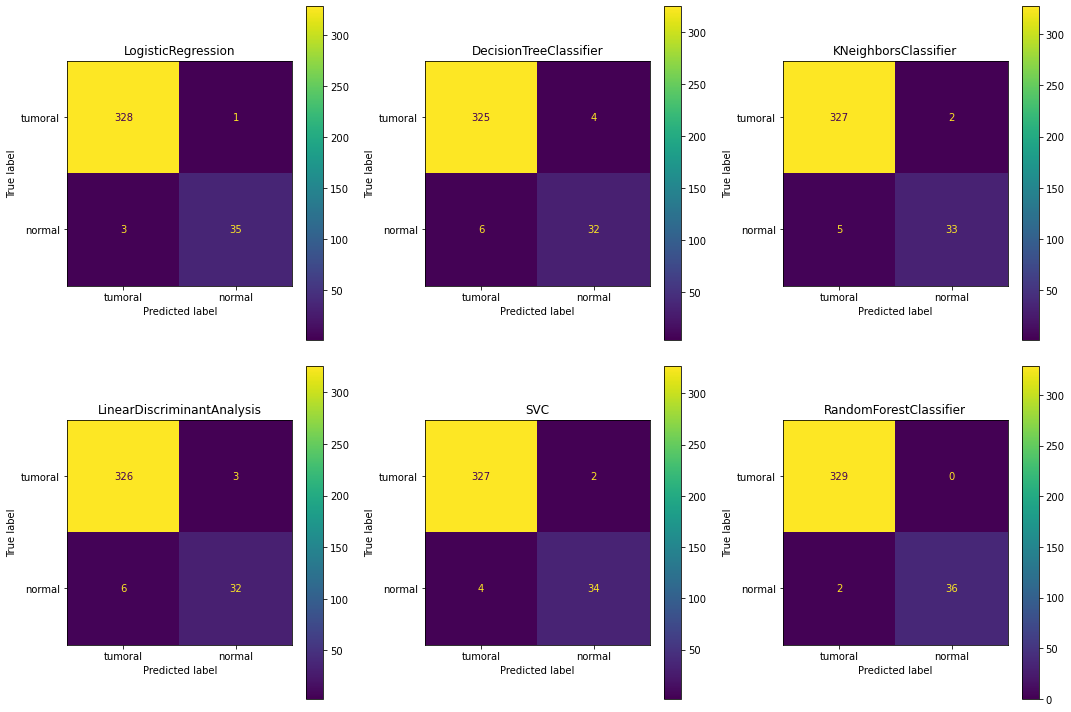

In [799]:
classifiers=[logreg,dt,knn,lda,svm,rf]

for cls in classifiers:
    cls.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    _=plot_confusion_matrix(cls,
                            X_test,
                            y_test, 
                            ax=ax,
                            normalize=None,
                            display_labels=['tumoral','normal'])
    ax.title.set_text(type(cls).__name__)
    


plt.tight_layout(w_pad=1.5, h_pad=2)  
plt.show()

LogisticRegression(penalty='none', solver='newton-cg')

DecisionTreeClassifier()

KNeighborsClassifier()

LinearDiscriminantAnalysis()

SVC()

RandomForestClassifier()

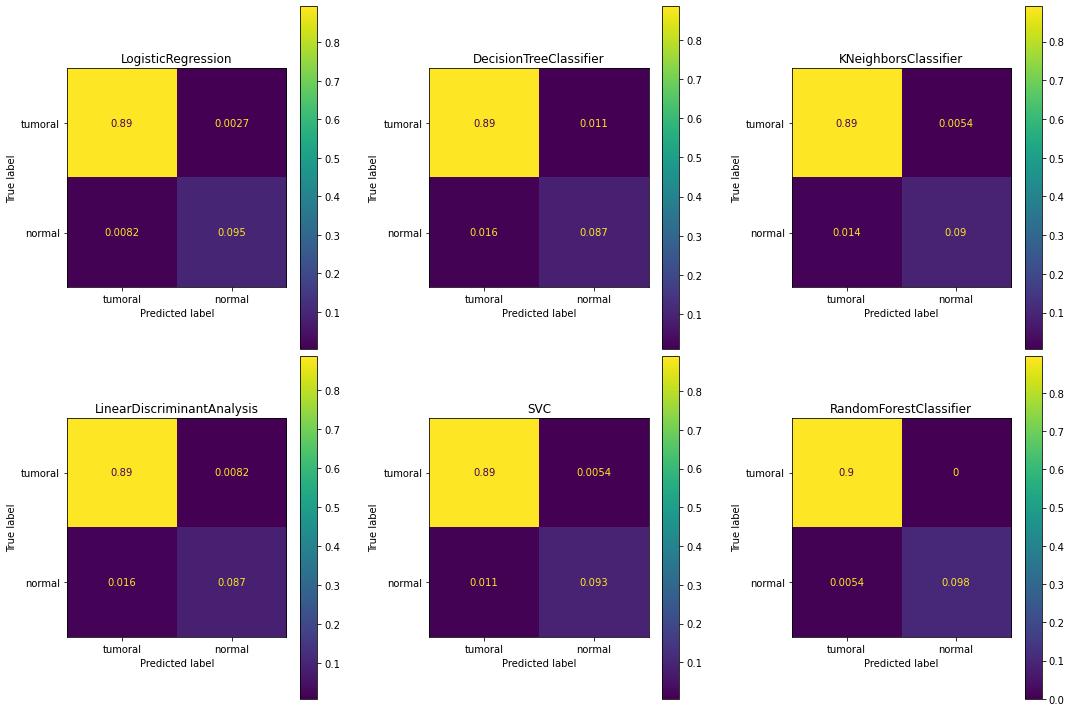

In [804]:
#Normalized confusion matrix
classifiers=[logreg,dt,knn,lda,svm,rf]

for cls in classifiers:
    cls.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    _=plot_confusion_matrix(cls,
                            X_test,
                            y_test, 
                            ax=ax,
                            normalize='all',
                            display_labels=['tumoral','normal'])
    ax.title.set_text(type(cls).__name__)
    


plt.tight_layout(w_pad=3, h_pad=0.1)  
plt.show()


## Hyperparameters tuning

The hyperparameters tuning aims to choose a set of optimal hyperparameters for a learning algorithm.

In [734]:
classifiers = [
    ("LogisticRegression", LogisticRegression(), {"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}),
    ("DecisionTree",DecisionTreeClassifier(),{"max_depth":[2,4,6,8,10,12]}),
    ("KNN", KNeighborsClassifier(), {"n_neighbors": range(1, 20)}),
    ("LDA", LinearDiscriminantAnalysis(), {"solver":["svd", "lsqr", "eigen"]}),
    ("SVM", SVC(), {"kernel":["linear", "poly", "rbf", "sigmoid"]}),
    ("RandomForest",RandomForestClassifier(),{"n_estimators": [1,10,20,30,50,100,200,300]}),
]

scores = []

#We divide our dataset in train and test 
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size = test_size, random_state = seed)

data_scores=pd.DataFrame()

for name, model, grid_params in classifiers:
    if grid_params is not None:
        grid = GridSearchCV(model, grid_params, cv=5, scoring='accuracy', return_train_score=False)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        score = grid.best_score_
        params= grid.best_params_
    else:
        model = model.fit(X, y)
        score = np.mean(cross_val_score(model, X, y, scoring="accuracy", cv=5))
        params='no_params_tested'

    
    scores=pd.DataFrame()
    scores['model']=[name]
    scores['best_score']=[score]
    scores['best_params']=[params]
    data_scores=pd.concat([data_scores,scores],axis=0)
        
        
        
# return_train_score=False:       
# However computing the scores on the training set can be computationally expensive 
# and is not strictly required to select the parameters that yield the best generalization performance.

/home/mariachiara/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mariachiara/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring='accuracy')

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20)}, scoring='accuracy')

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'solver': ['svd', 'lsqr', 'eigen']},
             scoring='accuracy')

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [1, 10, 20, 30, 50, 100, 200, 300]},
             scoring='accuracy')

In [735]:
data_scores

,model,best_score,best_params
0,LogisticRegression,0.992976,{'solver': 'sag'}
0,DecisionTree,0.987114,{'max_depth': 2}
0,KNN,0.981266,{'n_neighbors': 7}
0,LDA,0.968394,{'solver': 'svd'}
0,SVM,0.984775,{'kernel': 'rbf'}
0,RandomForest,0.992969,{'n_estimators': 50}


The hyperparamters tuning allow us to obtain more accurate models, even if using the default option we already obtained quite good models.
Testing the models on the test set we see the on average all of them reach an accuracy almost of 98%, so we can consider these performances good, allowing to classify correctly the majority of the samples.